In [96]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline 
import plotly.plotly as py
import numpy as np
import math
import warnings
from geopy.geocoders import Nominatim
import re
from collections import Counter
import csv
from itertools import izip_longest
import geoplotlib
from geoplotlib.utils import BoundingBox
from geoplotlib.colors import ColorMap
from sklearn import neighbors, cross_validation
import matplotlib
matplotlib.use('Agg')
from scipy.cluster.vq import *
import pylab
pylab.close()

# 1. Motivation

### What is your dataset?
We are using four different datasets from New York City;
* High school dropout rates: http://schools.nyc.gov/documents/misc/2016%20Graduation_Rates_Public_School.xlsx
* Locations of public houses: http://data.beta.nyc//dataset/c0eeb7e6-986e-4cbc-b3a1-d0df4900f79e/resource/5738dace-4bbf-4e0a-987e-798d8a1bb545/download/e5a7a8c2d3ac467ba81f76b075dfa363csvpublichousingrparegion.csv
* Trees planted in the city: https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/pi5s-9p35/data
* Crimes: https://data.cityofnewyork.us/Public-Safety/Historical-New-York-City-Crime-Data/hqhv-9zeg

### Why did you choose these particular datasets?
We chose these datasets to gain an understanding of the city, to be able to explore if there was any correlation between for example the number of trees and crimes, crime rate and dropout rate, and the locations of public houses and crimes.

### What was your goal for the end user's experience?
We wanted to extract interesting data so the end user would visually see these correlations. We have statistical plots, as well as clustering, some machine learning methods and d3-visualization. Hopefully, the end user will learn something about the city.

# 2. Basic stats. Let's understand the dataset better.

### Write about your choices in data cleaning and preprocessing.

Since we have four different data sets, we will describe the data cleaning and preprocessing separately, starting with the hardest one:

**High schools:**

This initial dataset was **30.3 MBs**, and contained **19290** observations, **24** features and six sheets for non-divided data. To make it easier to work with in pandas dataframes, we took the relevant information and in the end got three files, **7.1 MBs** (divided into schools, **36830** rows), **9.2 MBs** (divided into ethnicities, **76806** rows) and **4.9 MBs** (divided into genders, **37510** rows). We dropped the other information given.

We begin by reading in the dataset for all the schools, not containing any subgroups:

In [4]:
school_data = pd.read_excel("dropout2016.xls")

In [15]:
warnings.filterwarnings('ignore')
# we want to drop the rows that have a non-numeric value in the dropout percentage
school_data['dropoutperc'] = school_data['dropoutperc'].convert_objects(convert_numeric=True)
school_data = school_data.convert_objects(convert_numeric=True).dropna()

In [6]:
# The column names from Excel have lost their meaning, so we do some renaming:
school_data = school_data.rename(columns={'#': 'nrStudents'})

In [7]:
# First, we want to make a table for the 4 year August drop outs
# We extract the columns that we care about
new_school_data = school_data.reindex(columns=['schoolName', 'Category', 'Cohort', 'year', 'nrStudents', 'dropoutperc', 'lon', 'lat'])

Next, we do exactly the same things for the dataset that has ethnicity information:

In [16]:
warnings.filterwarnings('ignore')
ethnic_data = pd.read_csv('ethnicity.csv')

# we want to drop the rows that have a non-numeric value in the dropout percentage
ethnic_data['dropoutPerc'] = ethnic_data['dropoutPerc'].convert_objects(convert_numeric=True)
ethnic_data = ethnic_data.convert_objects(convert_numeric=True).dropna()

ethnic_data = ethnic_data.rename(columns={'#': 'nrStudents'})

# We extract the columns that we care about
new_ethnic_data = ethnic_data.reindex(columns=['schoolName', 'Category', 'Cohort Year', 'Cohort', 'nrStudents', 'dropoutPerc', 'lon', 'lat'])

And then gender:

In [17]:
warnings.filterwarnings('ignore')
gender_data = pd.read_csv('gender.csv')

gender_data['dropoutPerc'] = gender_data['dropoutPerc'].convert_objects(convert_numeric=True)
gender_data = gender_data.convert_objects(convert_numeric=True).dropna()

gender_data = gender_data.rename(columns={'#': 'nrStudents'})

# We extract the columns that we care about
new_gender_data = gender_data.reindex(columns=['schoolName', 'Category', 'Cohort Year', 'Cohort', 'nrStudents', 'dropoutPerc', 'lon', 'lat'])

Now for the strenuous part. We only had the names of the schools, not addresses or geo-coordinates. Here, it would maybe have been a good idea to drop this dataset, but we were really interested in the information it could give us, so we manually looked for addresses. 

In [10]:
# We take the unique school names to manually get their
# geo-coordinates. It's harder than initially thought, but
# we'd already started it!
school_name = school_data.schoolName.unique()

In [11]:
# We make it into a list
nameList = list(school_name)

This was a total of 518 schools to manually look up on Google Maps. Since there was no coding involved in that fun activity, we won't show the details. After that, we used Nominatim to get the geo-coordinates for a majority of the addresses.

In [13]:
# We display the updated address_list in an output cell so it's more compact
address_list_fix = ['220 Henry St, New York, NY 10002',
 '200 Monroe St, New York, NY 10002',
 '420 E 12th St, New York, NY 10009',
 '198 Forsyth St, New York, NY 10002',
 '145 Stanton St, New York, NY 10002',
 '145 Stanton St, New York, NY 10002',
 '415 E Houston St, New York, NY 10002 USA',
 '198 Forsyth St, New York, NY 10002',
 '525 E Houston St, New York, NY 10002',
 '225 E 23rd St, New York, NY 10010',
 '439 W 49th St, New York, NY 10019',
 '525 W 50th St, New York, NY 10019',
 '350 Grand St, New York, NY 10002',
 '525 W 50th St, New York, NY 10019',
 '100 Hester St, New York, NY 10002',
 '525 W 50th St, New York, NY 10019',
 '525 W 50th St, New York, NY 10019',
 '350 Grand St, New York, NY 10002',
 '350 Grand St, New York, NY 10002',
 '351 W 18th St, New York, NY 10011',
 '26 Broadway, New York, NY 10004',
 '40 Irving Pl, New York, NY 10003',
 '131 6th Ave, New York, NY 10013',
 '351 W 18th St, New York, NY 10011',
 '439 W 49th St, New York, NY 10019',
 '100 Hester St, New York, NY 10002',
 '40 Irving Pl, New York, NY 10003',
 '444 W 56th St, New York, NY 10019',
 '345 E 15th St, New York, NY 10003',
 '328 W 48th St, New York, NY 10036',
 '55 E 25th St, New York, NY 10010',
 '333 W 17th St, New York, NY 10011',
 '127 E 22nd St, New York, NY 10010',
 '333 W 17th St, New York, NY 10011',
 '411 E 76th St, New York, NY 10021',
 '75 Broad St, New York, NY 10004',
 '351 W 18th St, New York, NY 10011',
 '345 E 15th St, New York, NY 10003',
 '351 W 18th St, New York, NY 10011',
 '90 Trinity Pl, New York, NY 10006',
 '111 E 33rd St #526, New York, NY 10016',
 '34 W 14th St #2, New York, NY 10011',
 '111 E 33rd St, New York, NY 10016',
 '351 W 18th St, New York, NY 10011',
 '40 Irving Pl, New York, NY 10003',
 '43 W 22nd St, New York, NY 10010',
 '351 W 18th St, New York, NY 10011',
 '350 Grand St, New York, NY 10002',
 '317 E 67th St #401, New York, NY 10065',
 '317 E 67th St, New York, NY 10065',
 '40 Irving Pl, New York, NY 10003',
 '345 Chambers St, New York, NY 10282',
 '100 Trinity Pl, New York, NY 10006',
 '121 6th Ave, New York, NY 10013',
 '439 W 49th St, New York, NY 10019',
 '300 E 68th St, New York, NY 10065',
 '411 Pearl St, New York, NY 10038',
 '120 W 46th St, New York, NY 10036',
 '123 W 43rd St #2, New York, NY 10036',
 '40 Irving Pl, New York, NY 10003',
 '34 W 14th St, New York, NY 10011',
 '525 W 50th St, New York, NY 10019',
 '525 W 50th St, New York, NY 10019',
 '350 Grand St, New York, NY 10002',
 '850 10th Ave, New York, NY 10019',
 '350 Grand St, New York, NY 10002',
 '2474 Crotona Ave, Bronx, NY 10458',
 '250 W 18th St, New York, NY 10011',
 '10 South St, New York, NY 10004',
 '16 Clarkson St, New York, NY 10014',
 '317 E 67th St, New York, NY 10065',
 '120 W 30th St # L, New York, NY 10001',
 '240 2nd Ave, New York, NY 10003',
 '7 Beaver St, New York, NY 10004',
 '2 Astor Place, Fl 3, New York, NY 10003, United States',
 '225 W 24th St, New York, NY 10011',
 '351 W 18th St, New York, NY 10011',
 '131 6th Ave, New York, NY 10013',
 '111 E 33rd St, New York, NY 10016',
 '439 W 49th St, New York, NY 10019',
 '245 E 56th St, New York, NY 10022',
 '320 E 96th St, New York, NY 10128',
 '34 W 14th St #2, New York, NY 10011',
 '122 Amsterdam Ave, New York, NY 10023',
 '122 Amsterdam Ave, New York, NY 10023',
 '122 Amsterdam Ave, New York, NY 10023',
 '145 W 84th St, New York, NY 10024',
 '145 W 84th St, New York, NY 10024',
 '145 W 84th St, New York, NY 10024',
 '215 W 114th St, New York, NY 10026',
 '145 W 84th St, New York, NY 10024',
 '145 W 84th St, New York, NY 10024',
 '522 W 44th St, New York, NY 10036',
 '100 Amsterdam Ave, New York, NY 10023',
 '135 Locust Hill Ave, New York, NY 10701',
 '122 Amsterdam Ave, New York, NY 10023',
 '122 Amsterdam Ave, New York, NY 10023',
 '140 W 102nd St, New York, NY 10025',
 '122 Amsterdam Ave, New York, NY 10023',
 '215 W 114th St, New York, NY 10026',
 '240 E 109th St, New York, NY 10029',
 '2351 1st Avenue, New York, NY 10035',
 '280 Pleasant Ave, New York, NY 10029',
 '230 E 105th St, New York, NY 10029',
 '1573 Madison Ave, New York, NY 10029',
 '105 E 106th St #9, New York, NY 10029',
 '410 E 100th St, New York, NY 10029',
 '1680 Lexington Ave, New York, NY 10029',
 '2351 1st Avenue, New York, NY 10035',
 '2005 Madison Ave, New York, NY 10035',
 '22 E 128th St, New York, NY 10035',
 '6 Edgecombe Ave, New York, NY 10030',
 '425 W 123rd St, New York, NY 10027',
 '509 W 129th St, New York, NY 10027',
 '509 W 129th St, New York, NY 10027',
 '2005 Madison Ave, New York, NY 10035',
 '2581 Adam Clayton Powell Jr Blvd, New York, NY 10039',
 '200 W 135th St, New York, NY 10030',
 '135 W 50th St, New York, NY 10020',
 '240 Convent Ave, New York, NY 10031',
 '4600 Broadway, New York, NY 10040',
 '504 W 158th St, New York, NY 10032',
 '511 W 182nd St, New York, NY 10033',
 '650 Academy St, New York, NY 10034',
 '108-35 167th St, Queens, NY 11433',
 '549 Audubon Ave, New York, NY 10040',
 '549 Audubon Ave, New York, NY 10040',
 '549 Audubon Ave, New York, NY 10040',
 '443 W 135th St, New York, NY 10031',
 '501 W 165th St, New York, NY 10032',
 '360 E 145th St, Bronx, NY 10454',
 '360 E 145th St, Bronx, NY 10454',
 '455 Southern Blvd, Bronx, NY 10455',
 '345 Brook Ave, Bronx, NY 10454',
 '778 Forest Ave, Bronx, NY 10456',
 '333 E 151st St, Bronx, NY 10451',
 '350 Gerard Ave, Bronx, NY 10451',
 '890 Washington Ave, Bronx, NY 10451',
 "701 St Ann's Ave, Bronx, NY 10455",
 "701 St Ann's Ave, Bronx, NY 10455",
 "600 St Ann's Ave, Bronx, NY 10455",
 '470 Jackson Ave, Bronx, NY 10455',
 '333 E 151st St, Bronx, NY 10451',
 '730A Concourse Village W, Bronx, NY 10451',
 '730 Concourse Village W, Bronx, NY 10451',
 'Bronx, NY 10451',
 '339 Morris Ave, Bronx, NY 10451',
 '455 Southern Blvd, Bronx, NY 10455',
 '333 E 151st St, Bronx, NY 10451',
 '455 Southern Blvd, Bronx, NY 10455',
 '350 Gerard Ave, Bronx, NY 10451',
 '928 Simpson St, Bronx, NY 10459',
 '456 White Plains Rd, Bronx, NY 10473',
 '3000 E Tremont Ave, Bronx, NY 10461',
 '1980 Lafayette Ave, Bronx, NY 10473',
 '1980 Lafayette Ave # 4, Bronx, NY 10473',
 '1980 Lafayette Ave, Bronx, NY 10473',
 '3000 E Tremont Ave, Bronx, NY 10461',
 '965 Longwood Ave, Bronx, NY 10459',
 '3000 E Tremont Ave, Bronx, NY 10461',
 '3000 E Tremont Ave, Bronx, NY 10461',
 '456 White Plains Rd, Bronx, NY 10473',
 '1980 Lafayette Ave, Bronx, NY 10473',
 '1980 Lafayette Ave, Bronx, NY 10473',
 '3000 E Tremont Ave, Bronx, NY 10461',
 '1980 Lafayette Ave, Bronx, NY 10473',
 '1980 Lafayette Ave, Bronx, NY 10473',
 '1980 Lafayette Ave, Bronx, NY 10473',
 '1440 Story Ave, Bronx, NY 10473',
 '965 Longwood Ave, Bronx, NY 10459',
 '1440 Story Ave, Bronx, NY 10473',
 '1980 Lafayette Ave, Bronx, NY 10473',
 '3000 E Tremont Ave, Bronx, NY 10461',
 '900 Tinton Ave, Bronx, NY 10456',
 '1440 Story Ave, Bronx, NY 10473',
 '1980 Lafayette Ave, Bronx, NY 10473',
 '900 Tinton Ave, Bronx, NY 10456',
 '965 Longwood Ave, Bronx, NY 10459',
 '240 E 172nd St, Bronx, NY 10457',
 '4143 Third Ave, Bronx, NY 10457',
 '240 E 172nd St #477, Bronx, NY 10457',
 '1595 Bathgate Ave, Bronx, NY 10457',
 '1363 Fulton Ave, Bronx, NY 10456',
 '1595 Bathgate Ave, Bronx, NY 10457',
 '1363 Fulton Ave, Bronx, NY 10456',
 '1595 Bathgate Ave, Bronx, NY 10457',
 '1701 Fulton Ave, Bronx, NY 10457',
 '1100 Boston Rd, Bronx, NY 10456',
 '250 E 164th St, Bronx, NY 10456',
 '1501 Jerome Ave, Bronx, NY 10452',
 '240 E 172nd St, Bronx, NY 10457',
 '240 E 172nd St, Bronx, NY 10457',
 '1700 Macombs Rd, Bronx, NY 10453',
 '1100 Boston Rd, Bronx, NY 10456',
 '1100 Boston Rd, Bronx, NY 10456',
 '240 E 172nd St, Bronx, NY 10457',
 '240 E 172nd St, Bronx, NY 10457',
 '240 E 172nd St, Bronx, NY 10457',
 '244 E 163rd St, Bronx, NY 10451',
 '3630 Third Ave, Bronx, NY 10456',
 '1710 Webster Ave, Bronx, NY 10457',
 '1100 Boston Rd, Bronx, NY 10456',
 '240 E 172nd St, Bronx, NY 10457',
 '660 W 236th St, Bronx, NY 10463',
 '99 Terrace View Ave, Bronx, NY 10463',
 '2225 Webster Avenue, Bronx, NY 10457, United States',
 '120 W 231st St, Bronx, NY 10463',
 '500 E Fordham Rd, Bronx, NY 10458',
 '2474 Crotona Ave, Bronx, NY 10458',
 '2780 Reservoir Ave, Bronx, NY 10468',
 '99 Terrace View Ave, Bronx, NY 10463',
 '560 E 179th St, Bronx, NY 10457',
 '2780 Reservoir Ave, Bronx, NY 10468',
 '3rd Floor North, 100 W Mosholu Pkwy S, Bronx, NY 10468, United States',
 '2975 Tibbett Ave, Bronx, NY 10463',
 '500 E Fordham Rd, Bronx, NY 10458',
 '99 Terrace View Ave, Bronx, NY 10463',
 '240 E 172nd St, Bronx, NY 10457',
 '240 E 172nd St, Bronx, NY 10457',
 '2780 Reservoir Ave, Bronx, NY 10468',
 '500 E Fordham Rd, Bronx, NY 10458',
 '500 E Fordham Rd, Bronx, NY 10458',
 '500 E Fordham Rd, Bronx, NY 10458',
 '500 E Fordham Rd, Bronx, NY 10458',
 '500 E Fordham Rd, Bronx, NY 10458',
 '100 W Mosholu Pkwy S, Bronx, NY 10468',
 '2780 Reservoir Ave, Bronx, NY 10468',
 '75 W 205th St, Bronx, NY 10468',
 '99 Terrace View Ave, Bronx, NY 10463',
 '99 Terrace View Ave, Bronx, NY 10463',
 '2474 Crotona Ave, Bronx, NY 10458',
 '99 Terrace View Ave, Bronx, NY 10463',
 '2780 Reservoir Ave, Bronx, NY 10468',
 '2474 Crotona Ave, Bronx, NY 10458',
 '2474 Crotona Ave, Bronx, NY 10458',
 '2925 Goulden Ave, Bronx, NY 10468',
 '750 Baychester Ave, Bronx, NY 10475',
 '800 E Gun Hill Rd, Bronx, NY 10467',
 '800 E Gun Hill Rd, Bronx, NY 10467',
 '921 E 228th St, Bronx, NY 10466',
 '800 E Gun Hill Rd, Bronx, NY 10467',
 '925 Astor Ave, Bronx, NY 10469',
 '800 E Gun Hill Rd, Bronx, NY 10467',
 '925 Astor Ave, Bronx, NY 10469',
 '925 Astor Ave, Bronx, NY 10469',
 '50 Antin Pl, Bronx, NY 10462',
 '800 E Gun Hill Rd, Bronx, NY 10467',
 '750 Baychester Ave, Bronx, NY 10475',
 '925 Astor Ave, Bronx, NY 10469',
 '925 Astor Ave, Bronx, NY 10469',
 '921 E 228th St, Bronx, NY 10466',
 '921 E 228th St, Bronx, NY 10466',
 'Bronx, NY 10469',
 '925 Astor Ave, Bronx, NY 10469',
 '800 E Gun Hill Rd, Bronx, NY 10467',
 '800 E Gun Hill Rd, Bronx, NY 10467',
 '1551 E 172nd St, Bronx, NY 10472',
 '800 Home St, Bronx, NY 10456',
 '1180 Rev James A Polite Ave, Bronx, NY 10459',
 '1619 Boston Rd, Bronx, NY 10460',
 '1619 Boston Rd, Bronx, NY 10460',
 '800 Home St #426, Bronx, NY 10456',
 '1716 Southern Blvd, Bronx, NY 10460',
 '1180 Rev James A Polite Ave, Bronx, NY 10459',
 "639 St Ann's Ave, Bronx, NY 10455",
 '2024 Mohegan Ave, Bronx, NY 10460',
 '1300 Boynton Ave, Bronx, NY 10472',
 '1010 Rev James A Polite Ave, Bronx, NY 10459',
 '1551 E 172nd St, Bronx, NY 10472',
 '800 Home St, Bronx, NY 10456',
 '1010 Rev James A Polite Ave, Bronx, NY 10459',
 '1619 Boston Rd, Bronx, NY 10460',
 '1300 Boynton Ave, Bronx, NY 10472',
 '1300 Boynton Ave, Bronx, NY 10472',
 '1300 Boynton Ave, Bronx, NY 10472',
 '10001, Jennings St, Bronx, NY 10460, United States',
 '1122 E 180th St, Bronx, NY 10460',
 '1300 Boynton Ave, Bronx, NY 10472',
 '1300 Boynton Ave, Bronx, NY 10472',
 '101 Park Ave, Brooklyn, NY 11205',
 '141 Macon St, Brooklyn, NY 11216',
 '49 Flatbush Ave Ext, Brooklyn, NY 11201',
 '300 Willoughby Ave, Brooklyn, NY 11205',
 '49 Flatbush Ave Ext, Brooklyn, NY 11201',
 '29 Fort Greene Pl, Brooklyn, NY 11217',
 '49 Flatbush Ave Ext, Brooklyn, NY 11201',
 '283 Adams St, Brooklyn, NY 11201',
 '561 Grand Ave, Brooklyn, NY 11238',
 '116 Nassau St, Brooklyn, NY 11201',
 '283 Adams St, Brooklyn, NY 11201',
 '832 Marcy Ave, Brooklyn, NY 11216',
 '832 Marcy Ave, Brooklyn, NY 11216',
 '1119 Bedford Ave, Brooklyn, NY 11216',
 '105 Tech Pl, Brooklyn, NY 11201',
 'Willoughby Ave, Brooklyn, NY 11205',
 '77 Clinton Ave, Brooklyn, NY 11205',
 '105 Tech Pl, Brooklyn, NY 11201',
 '215 Heyward St, Brooklyn, NY 11206',
 '70 Tompkins Ave, Brooklyn, NY 11206',
 '223 Graham Ave, Brooklyn, NY 11206',
 '223 Graham Ave, Brooklyn, NY 11206',
 '850 Grand St, Brooklyn, NY 11211',
 '850 Grand St, Brooklyn, NY 11211',
 '850 Grand St, Brooklyn, NY 11211',
 '257 N 6th St, Brooklyn, NY 11211',
 '257 N 6th St, Brooklyn, NY 11211',
 '257 N 6th St, Brooklyn, NY 11211',
 '223 Graham Ave #337b, Brooklyn, NY 11206',
 '50 Bedford Ave, Brooklyn, NY 11222',
 '325 Bushwick Ave, Brooklyn, NY 11206',
 '50 Bedford Ave, Brooklyn, NY 11222',
 '257 N 6th St, Brooklyn, NY 11211',
 '250 Hooper St, Brooklyn, NY 11211',
 '27 Huntington St, Brooklyn, NY 11231',
 '112 Schermerhorn St, Brooklyn, NY 11201',
 '284 Baltic St, Brooklyn, NY 11201',
 '610 Henry St, Brooklyn, NY 11231',
 '237 7th Ave, Brooklyn, NY 11215',
 '237 7th Ave, Brooklyn, NY 11215',
 '237 7th Ave, Brooklyn, NY 11215',
 '237 7th Ave, Brooklyn, NY 11215',
 '284 Baltic St, Brooklyn, NY 11201',
 '347 Baltic St, Brooklyn, NY 11201',
 '112 Schermerhorn St, Brooklyn, NY 11201',
 '1053 41st St, Brooklyn, NY 11219',
 '362 Schermerhorn St, Brooklyn, NY 11217',
 '362 Schermerhorn St, Brooklyn, NY 11217',
 '345 Dean St, Brooklyn, NY 11217',
 '153 35th St, Brooklyn, NY 11232',
 '237 7th Ave, Brooklyn, NY 11215',
 '173 Conover St, Brooklyn, NY 11231',
 '1014 Lafayette Ave, Brooklyn, NY 11221',
 '1700 Fulton St, Brooklyn, NY 11213',
 '1396 Broadway, Brooklyn, NY 11221',
 '265 Ralph Ave, Brooklyn, NY 11233',
 '1700 Fulton St, Brooklyn, NY 11213',
 '125 Stuyvesant Ave, Brooklyn, NY 11221',
 '1700 Fulton St, Brooklyn, NY 11213',
 '150 Albany Ave, Brooklyn, NY 11213',
 '911 Flatbush Ave, Brooklyn, NY 11226',
 '911 Flatbush Ave, Brooklyn, NY 11226',
 '883 Classon Ave, Brooklyn, NY 11225',
 '911 Flatbush Ave, Brooklyn, NY 11226',
 '911 Flatbush Ave, Brooklyn, NY 11226',
 '600 Kingston Ave, Brooklyn, NY 11203',
 '850 Grand St, Brooklyn, NY 11211',
 '402 Eastern Pkwy, Brooklyn, NY 11225',
 '883 Classon Ave, Brooklyn, NY 11225',
 '883 Classon Ave, Brooklyn, NY 11225',
 '600 Kingston Ave, Brooklyn, NY 11203',
 '600 Kingston Ave, Brooklyn, NY 11203',
 '911 Flatbush Ave, Brooklyn, NY 11226',
 '911 Flatbush Avenue, Brooklyn, NY 11203',
 '911 Flatbush Ave, Brooklyn, NY 11226',
 '600 Kingston Ave, Brooklyn, NY 11203',
 '600 Kingston Ave, Brooklyn, NY 11203',
 '883 Classon Ave, Brooklyn, NY 11225',
 '883 Classon Ave, Brooklyn, NY 11225',
 '1150 E New York Ave, Brooklyn, NY 11212',
 '1186 Carroll St, Brooklyn, NY 11225',
 '901 Classon Ave, Brooklyn, NY 11225',
 '150 Albany Ave, Brooklyn, NY 11213',
 '600 Kingston Ave, Brooklyn, NY 11203',
 '150 Albany Ave, Brooklyn, NY 11213',
 '5800 Tilden Ave, Brooklyn, NY 11203',
 '1600 Rockaway Pkwy, Brooklyn, NY 11236',
 '6565 Flatlands Ave, Brooklyn, NY 11236',
 '5800 Tilden Ave, Brooklyn, NY 11203',
 '6565 Flatlands Ave, Brooklyn, NY 11236',
 '6565 Flatlands Ave, Brooklyn, NY 11236',
 '5800 Tilden Ave, Brooklyn, NY 11203',
 '6565 Flatlands Ave, Brooklyn, NY 11236',
 '6565 Flatlands Ave, Brooklyn, NY 11236',
 '905 Winthrop St, Brooklyn, NY 11203',
 '1600 Rockaway Pkwy, Brooklyn, NY 11236',
 '5800 Tilden Ave, Brooklyn, NY 11203',
 '1600 Rockaway Pkwy, Brooklyn, NY 11236',
 '755 East 100th Street, Brooklyn, NY 11236',
 '6565 Flatlands Ave, Brooklyn, NY 11236',
 '1600 Rockaway Pkwy, Brooklyn, NY 11236',
 '9517 Kings Hwy, Brooklyn, NY 11212',
 '1065 Elton St, Brooklyn, NY 11239',
 '2057 Linden Blvd, Brooklyn, NY 11207',
 '999 Jamaica Ave, Brooklyn, NY 11208',
 '400 Pennsylvania Ave, Brooklyn, NY 11207',
 '400 Pennsylvania Ave, Brooklyn, NY 11207',
 '400 Pennsylvania Ave, Brooklyn, NY 11207',
 '400 Pennsylvania Ave, Brooklyn, NY 11207',
 '400 Pennsylvania Ave, Brooklyn, NY 11207',
 '999 Jamaica Ave, Brooklyn, NY 11208',
 '1 Wells St, Brooklyn, NY 11208',
 '999 Jamaica Ave, Brooklyn, NY 11208',
 '999 Jamaica Ave, Brooklyn, NY 11208',
 '999 Jamaica Ave, Brooklyn, NY 11208',
 '145 Pennsylvan Ave, Brooklyn, NY 11207',
 '370 Fountain Ave, Brooklyn, NY 11208',
 '999 Jamaica Ave, Brooklyn, NY 11208',
 '1601 80th St, Brooklyn, NY 11214',
 '350 67th St, Brooklyn, NY 11220',
 '8301 Shore Rd, Brooklyn, NY 11209',
 '5800 20th Ave, Brooklyn, NY 11204',
 '4200 16th Ave, Brooklyn, NY 11204',
 '2630 Benson Ave, Brooklyn, NY 11214',
 '521 West Ave, Brooklyn, NY 11224',
 '2630 Benson Ave, Brooklyn, NY 11214',
 '2630 Benson Ave, Brooklyn, NY 11214',
 '2800 Ocean Pkwy, Brooklyn, NY 11235',
 '2630 Benson Ave, Brooklyn, NY 11214',
 '1600 Avenue L, Brooklyn, NY 11230',
 '50 Avenue X, Brooklyn, NY 11223',
 '2630 Benson Ave, Brooklyn, NY 11214',
 '2630 Benson Ave, Brooklyn, NY 11214',
 '25 Brighton 4th Rd, Brooklyn, NY 11235',
 '8310 21st Ave, Brooklyn, NY 11214',
 '2865 W 19th St, Brooklyn, NY 11224',
 '2839 Bedford Ave, Brooklyn, NY 11210',
 '3787 Bedford Ave, Brooklyn, NY 11229',
 '3000 Avenue X, Brooklyn, NY 11235',
 '1830 Shore Blvd, Brooklyn, NY 11235',
 'Brooklyn College, 2900 Bedford Ave # 1311JAMES, Brooklyn, NY 11210',
 '2501 86th St, Brooklyn, NY 11214',
 '3000 Avenue X, Brooklyn, NY 11235',
 '3000 Avenue X, Brooklyn, NY 11235',
 '2021 Bergen St, Brooklyn, NY 11233',
 '226 Bristol St, Brooklyn, NY 11212',
 '985 Rockaway Ave, Brooklyn, NY 11212',
 '1137 Herkimer St, Brooklyn, NY 11233',
 '1495 Herkimer St, Brooklyn, NY 11233',
 '1495 Herkimer St #1, Brooklyn, NY 11233',
 '985 Rockaway Ave, Brooklyn, NY 11212',
 'Brooklyn, NY 11212',
 '48-01 90th St, Queens, NY 11373',
 '30-20 Thomson Ave, Queens, NY 11101',
 '30-20 Thomson Ave, Queens, NY 11101',
 '45-10 94th St, Queens, NY 11373',
 '45-10 94th St, Queens, NY 11373',
 '30-20 Thomson Ave, Queens, NY 11101',
 '48-01 90th St, Queens, NY 11373',
 '21-27 Himrod St, Queens, NY 11385',
 '3101 Thomson Ave, Queens, NY 11101',
 '45-35 Van Dam St, Queens, NY 11101',
 '105-25 Horace Harding Expy, Queens, NY 11368',
 '4707 30th Pl, Queens, NY 11101',
 '54-40 74th St, Queens, NY 11373',
 '37-02 47th Ave, Queens, NY 11101',
 '45-30 36th St, Queens, NY 11101',
 '45-10 94th St, Queens, NY 11373',
 '35-01 Union St, Queens, NY 11354',
 '158-40 76th Rd, Queens, NY 11366',
 '144-80 Barclay Ave, Queens, NY 11355',
 '46-21 Colden St, Queens, NY 11355',
 '34-65 192nd St, Queens, NY 11358',
 '63-25 Main St, Queens, NY 11367',
 '35-01 Union St, Queens, NY 11354',
 '149-11 Melbourne Ave, Queens, NY 11367',
 '14210 Linden Blvd, Queens, NY 11436',
 '75-40 Parsons Blvd, Queens, NY 11366',
 '14125 77th Rd, Queens, NY 11367',
 '5700 223rd St, Queens, NY 11364',
 '58-20 Utopia Pkwy, Queens, NY 11365',
 '230-17 Hillside Avenue, Queens, NY 11427',
 '3224 Corporal Kennedy St, Queens, NY 11361',
 '7420 Commonwealth Blvd, Queens, NY 11426',
 '8-21 Bay 25th St, Queens, NY 11691',
 '156-10 Baisley Blvd, Queens, NY 11434',
 '100-00 Beach Channel Dr, Queens, NY 11694',
 '8-21 Bay 25th St, Queens, NY 11691',
 '138-30 Lafayette St, Queens, NY 11417',
 '8-21 Bay 25th St, Queens, NY 11691',
 '320 Beach 104th St, Queens, NY 11694',
 '100-00 Beach Channel Dr, Queens, NY 11694',
 '100-00 Beach Channel Dr, Queens, NY 11694',
 '156-10 Baisley Blvd, Queens, NY 11434',
 '100-00 Beach Channel Dr, Queens, NY 11694',
 '821 Bay 25th St, Queens, NY 11691',
 '89-30 114th St, Queens, NY 11418',
 '101-01 Rockaway Blvd, Queens, NY 11417',
 '94-06 104th St, Queens, NY 11416',
 '63-55 102nd St, Queens, NY 11374',
 '91-30 Metropolitan Ave, Queens, NY 11375',
 '108-35 167th St, Queens, NY 11433',
 '167-01 Gothic Dr, Queens, NY 11432',
 '167-01 Gothic Dr, Queens, NY 11432',
 '167-01 Gothic Dr, Queens, NY 11432',
 '162-02 Hillside Avenue, Queens, NY 11432',
 '167-01 Gothic Dr, Queens, NY 11432',
 '67-01 110th St, Queens, NY 11375',
 '167-01 Gothic Dr, Queens, NY 11432',
 '160-05 Highland Ave, Queens, NY 11432',
 '165-65 84th Ave, Queens, NY 11432',
 '160-20 Goethals Ave, Queens, NY 11432',
 '91-30 Metropolitan Ave, Queens, NY 11375',
 '11451, 94-50 159th St, Queens, NY 11433, United States',
 '116-25 Guy R Brewer Blvd, Queens, NY 11434',
 '150-91 87th Rd, Queens, NY 11432',
 '207-01 116th Ave, Queens, NY 11411',
 '143-10 Springfield Blvd, Queens, NY 11413',
 '109-89 204th St, Queens, NY 11412',
 '143-10 Springfield Blvd, Queens, NY 11413',
 '143-10 Springfield Blvd, Queens, NY 11413',
 '143-10 Springfield Blvd, Queens, NY 11413',
 '188-04 91st Ave, Queens, NY 11423',
 '4143 Third Ave, Bronx, NY 10457',
 '143-10 Springfield Blvd, Queens, NY 11413',
 '207-01 116th Ave, Queens, NY 11411',
 '207-01 116th Ave, Queens, NY 11411',
 '207-01 116th Ave, Queens, NY 11411',
 '207-01 116th Ave, Queens, NY 11411',
 '23-15 Newtown Ave, Queens, NY 11102',
 '1-50 51st Ave #411, Queens, NY 11101',
 '4810 31st Ave, Queens, NY 11103',
 '14-30 Broadway, Queens, NY 11106',
 '35-12 35th Ave, Queens, NY 11106',
 '21-16 44th Rd, Queens, NY 11101',
 '28-01 41st Ave, Queens, NY 11101',
 '28-04 41st Ave, Queens, NY 11101',
 '34-12 36th Ave, Queens, NY 11106',
 '100 Essex Dr, Staten Island, NY 10314',
 '100 Essex Dr, Staten Island, NY 10314',
 '715 Ocean Terrace, Staten Island, NY 10301',
 '465 New Dorp Ln, Staten Island, NY 10306',
 '85 St Josephs Ave, Staten Island, NY 10302',
 '105 Hamilton Ave, Staten Island, NY 10301',
 '100 Luten Ave, Staten Island, NY 10312',
 '1200 Manor Rd, Staten Island, NY 10314',
 '109 Rhine Ave, Staten Island, NY 10304',
 '290 St Marks Pl, Staten Island, NY 10301',
 '485 Clawson St, Staten Island, NY 10306',
 '400 Irving Ave, Brooklyn, NY 11237',
 '400 Irving Ave, Brooklyn, NY 11237',
 'Brooklyn, NY 11221',
 '1155 Dekalb Ave, Brooklyn, NY 11221',
 '400 Irving Ave, Brooklyn, NY 11237',
 '400 Irving Ave, Brooklyn, NY 11221',
 '321 Palmetto St, Brooklyn, NY 11237',
 '797 Bushwick Ave, Brooklyn, NY 11221',
 '231 Palmetto St, Brooklyn, NY 11221']

In [ ]:
geolocator = Nominatim()

# After the lonLat is formed we copy the list and fix
# the addresses that we didn't get the geo-coordinates
# from
# The address list we have manually made is called address_list:
lonLat = []
for i in range(len(address_list_fix)):
    location = geolocator.geocode(address_list_fix[i])
    if location == None:
        lonLat.append(address_list_fix[i])
    else:
        lonLat.append((location.latitude, location.longitude))

In [14]:
# We do the same for the list of geocoordinates:
lonLatFix = [(40.7142645, -73.9809229),
 (40.71225365, -73.9839750348175),
 (40.7290878, -73.9825163483761),
 (40.7224227, -73.9906001),
 (40.7201826, -73.9861014321289),
 (40.7201826, -73.9861014321289),
 (40.719387, -73.979781),
 (40.7224227, -73.9906001),
 (40.718092, -73.976128),
 (40.7412181, -73.9887873),
 (40.76367915, -73.9903460995945),
 (40.7655507, -73.9935842),
 (40.7147219, -73.9825283),
 (40.7655507, -73.9935842),
 (40.716184, -73.9935207255638),
 (40.7655507, -73.9935842),
 (40.7655507, -73.9935842),
 (40.7147219, -73.9825283),
 (40.7147219, -73.9825283),
 (40.74336655, -74.0027635652581),
 (40.7053128, -74.0129106229046),
 (40.7355392, -73.9874497),
 (40.723767, -74.004844),
 (40.74336655, -74.0027635652581),
 (40.76367915, -73.9903460995945),
 (40.716184, -73.9935207255638),
 (40.7355392, -73.9874497),
 (40.7679284, -73.988097),
 (40.732708, -73.982641),
 (40.7615114, -73.9886383),
 (40.7417975, -73.9859409),
 (40.7424139, -74.0025155),
 (40.740685, -73.9896023),
 (40.7424139, -74.0025155),
 (40.7702874, -73.9532702536936),
 (40.7047334, -74.0114053),
 (40.74336655, -74.0027635652581),
 (40.732708, -73.982641),
 (40.74336655, -74.0027635652581),
 (40.745926, -73.978851),
 (40.746426, -73.981167),
 (40.73657, -73.995516),
 (40.7462177, -73.9809815),
 (40.74336655, -74.0027635652581),
 (40.7355392, -73.9874497),
 (40.7415404285714, -73.9914191428571),
 (40.74336655, -74.0027635652581),
 (40.7147219, -73.9825283),
 (40.765409, -73.959814),
 (40.76557985, -73.9596032617638),
 (40.7355392, -73.9874497),
 (40.7179876, -74.0138419443421),
 (40.709228, -74.0121822),
 (40.7278344, -74.0030835),
 (40.76367915, -73.9903460995945),
 (40.7660582, -73.9600568),
 (40.7114702, -74.0011693),
 (40.757624, -73.983505),
 (40.757624, -73.983505),
 (40.7355392, -73.9874497),
 (40.7366674, -73.9955978),
 (40.7655507, -73.9935842),
 (40.7655507, -73.9935842),
 (40.7147219, -73.9825283),
 (40.7680257, -73.9891223),
 (40.7147219, -73.9825283),
 (40.8552778, -73.8824999),
 (40.74183, -74.000396),
 (40.70098785, -74.0116506115877),
 (40.7293243, -74.0063103),
 (40.76557985, -73.9596032617638),
 (40.74748, -73.990722),
 (40.723986, -73.9909866),
 (40.7050995, -74.0129715),
 (40.729973, -73.992705),
 (40.745696, -73.996619),
 (40.74336655, -74.0027635652581),
 (40.723767, -74.004844),
 (40.7462177, -73.9809815),
 (40.76367915, -73.9903460995945),
 (40.7592191428571, -73.9669503469388),
 (40.7835893, -73.9459515),
 (40.73657, -73.995516),
 (40.77489495, -73.9856422934918),
 (40.77489495, -73.9856422934918),
 (40.77489495, -73.9856422934918),
 (40.785978, -73.974201),
 (40.785978, -73.974201),
 (40.785978, -73.974201),
 (40.8026256, -73.9542185),
 (40.785978, -73.974201),
 (40.785978, -73.974201),
 (40.7613364347826, -73.9957274347826),
 (40.77418495, -73.9859719946164),
 (40.9386681405803, -73.8952523225607),
 (40.77489495, -73.9856422934918),
 (40.77489495, -73.9856422934918),
 (40.79712195, -73.9667842074009),
 (40.77489495, -73.9856422934918),
 (40.8026256, -73.9542185),
 (40.7922885, -73.9416017),
 (40.79930915, -73.9341824237618),
 (40.7948221428571, -73.9332013469388),
 (40.79018675, -73.9440121628272),
 (40.7937647, -73.9484635194003),
 (40.79293755, -73.9471683),
 (40.785175, -73.9420182),
 (40.7919962, -73.9467717210058),
 (40.79930915, -73.9341824237618),
 (40.8069766, -73.9386113489948),
 (40.80775495, -73.939940084534),
 (40.8173228, -73.947082),
 (40.8107133, -73.956233),
 (40.8159758, -73.9556649),
 (40.8159758, -73.9556649),
 (40.8069766, -73.9386113489948),
 (40.8243845, -73.9366892),
 (40.8152441, -73.9443156573238),
 (40.7608683, -73.9823968),
 (40.82147395, -73.9490461998348),
 (40.86093735, -73.9300600751989),
 (40.8335188367347, -73.9418766530612),
 (40.84923795, -73.9309074236737),
 (40.8656163, -73.924801),
 (40.697083, -73.786685),
 (40.8555093, -73.9262633470974),
 (40.8555093, -73.9262633470974),
 (40.8555093, -73.9262633470974),
 (40.81837785, -73.9503247317164),
 (40.83839235, -73.9385934617747),
 (40.8136604, -73.9202944),
 (40.8136604, -73.9202944),
 (40.8101353333333, -73.9071566666667),
 (40.8101008, -73.9184701),
 (40.8188475, -73.9050628),
 (40.81862835, -73.920291170937),
 (40.8155463, -73.9304407),
 (40.8231641333333, -73.9111884),
 (40.8183204, -73.9111831),
 (40.8183204, -73.9111831),
 (40.81467045, -73.9120040781003),
 (40.8110683, -73.9095219),
 (40.81862835, -73.920291170937),
 (40.8227273918919, -73.9234791621622),
 (40.8224316, -73.9229432),
 (40.8204529346818, -73.9198036580767),
 (40.8136235, -73.9260635),
 (40.8101353333333, -73.9071566666667),
 (40.81862835, -73.920291170937),
 (40.8101353333333, -73.9071566666667),
 (40.8155463, -73.9304407),
 (40.8203974, -73.8929806885775),
 (40.8149897, -73.856075993216),
 (40.8399325, -73.8391577557417),
 (40.8209151, -73.8558568),
 (40.8209151, -73.8558568),
 (40.8209151, -73.8558568),
 (40.8399325, -73.8391577557417),
 (40.8176007, -73.8979846),
 (40.8399325, -73.8391577557417),
 (40.8399325, -73.8391577557417),
 (40.8149897, -73.856075993216),
 (40.8209151, -73.8558568),
 (40.8209151, -73.8558568),
 (40.8399325, -73.8391577557417),
 (40.8209151, -73.8558568),
 (40.8209151, -73.8558568),
 (40.8209151, -73.8558568),
 (40.82078665, -73.8807533855072),
 (40.8176007, -73.8979846),
 (40.82078665, -73.8807533855072),
 (40.8209151, -73.8558568),
 (40.8399325, -73.8391577557417),
 (40.8217383, -73.9026559678839),
 (40.82078665, -73.8807533855072),
 (40.8209151, -73.8558568),
 (40.8217383, -73.9026559678839),
 (40.8176007, -73.8979846),
 (40.83944, -73.911745),
 (40.833651, -73.904055),
 (40.83944, -73.911745),
 (40.8395136, -73.9018472911468),
 (40.8339229, -73.9028753),
 (40.8395136, -73.9018472911468),
 (40.8339229, -73.9028753),
 (40.8395136, -73.9018472911468),
 (40.8412244, -73.898683734162),
 (40.827316, -73.90472),
 (40.82809765, -73.9176544960612),
 (40.842483, -73.916202),
 (40.83944, -73.911745),
 (40.83944, -73.911745),
 (40.8494748, -73.9156113),
 (40.827316, -73.90472),
 (40.827316, -73.90472),
 (40.83944, -73.911745),
 (40.83944, -73.911745),
 (40.83944, -73.911745),
 (40.8274856, -73.9190268586198),
 (40.833651, -73.904055),
 (40.8433249, -73.9028965),
 (40.827316, -73.90472),
 (40.83944, -73.911745),
 (40.8868453, -73.9143265456581),
 (40.877505, -73.913666),
 (40.8544561, -73.897180294417),
 (40.8756121, -73.9017234467755),
 (40.8598397, -73.888295),
 (40.8552778, -73.8824999),
 (40.8701955, -73.8964684),
 (40.87757, -73.913451),
 (40.84830015, -73.8935756102176),
 (40.8701955, -73.8964684),
 (40.8813165, -73.8873388847277),
 (40.8773888, -73.9145040143251),
 (40.8598397, -73.888295),
 (40.87757, -73.913451),
 (40.83944, -73.911745),
 (40.8701955, -73.8964684),
 (40.8701955, -73.8964684),
 (40.8598397, -73.888295),
 (40.8598397, -73.888295),
 (40.8598397, -73.888295),
 (40.8598397, -73.888295),
 (40.8598397, -73.888295),
 (40.8813165, -73.8873388847277),
 (40.8701955, -73.8964684),
 (40.8776701724138, -73.8910282068966),
 (40.87757, -73.913451),
 (40.87757, -73.913451),
 (40.8552778, -73.8824999),
 (40.87757, -73.913451),
 (40.8701955, -73.8964684),
 (40.8552778, -73.8824999),
 (40.8552778, -73.8824999),
 (40.87477195, -73.8951985992977),
 (40.87410125, -73.8322403815423),
 (40.8755487, -73.8614233),
 (40.8755487, -73.8614233),
 (40.88821535, -73.8527200052426),
 (40.8755487, -73.8614233),
 (40.8598996, -73.8603221),
 (40.8755487, -73.8614233),
 (40.8598996, -73.8603221),
 (40.8598996, -73.8603221),
 (40.851071, -73.865438),
 (40.8755487, -73.8614233),
 (40.87410125, -73.8322403815423),
 (40.8598996, -73.8603221),
 (40.8598996, -73.8603221),
 (40.88821535, -73.8527200052426),
 (40.88821535, -73.8527200052426),
 (40.8657425, -73.8596887),
 (40.8598996, -73.8603221),
 (40.8755487, -73.8614233),
 (40.8755487, -73.8614233),
 (40.8316075, -73.8781015),
 (40.8277475, -73.9006719),
 (40.827433, -73.897428),
 (40.83633135, -73.8903249046069),
 (40.83633135, -73.8903249046069),
 (40.827388, -73.900829),
 (40.836821, -73.8876843886778),
 (40.827297, -73.897371),
 (40.81721865, -73.9118151342516),
 (40.8440014, -73.8845354),
 (40.8318142, -73.8787018),
 (40.823449, -73.898566),
 (40.8316075, -73.8781015),
 (40.8277475, -73.9006719),
 (40.823449, -73.898566),
 (40.83633135, -73.8903249046069),
 (40.8318142, -73.8787018),
 (40.8318142, -73.8787018),
 (40.8318142, -73.8787018),
 (40.831201, -73.8872289),
 (40.8415106, -73.8749294),
 (40.8318142, -73.8787018),
 (40.8318142, -73.8787018),
 (40.69698295, -73.9760811745642),
 (40.68191795, -73.945596595504),
 (40.69735, -73.984717),
 (40.6925521, -73.9583386),
 (40.69735, -73.984717),
 (40.6893351, -73.9763679),
 (40.69735, -73.984717),
 (40.701592, -73.9886269),
 (40.6784674615385, -73.9620100769231),
 (40.69827775, -73.986520898712),
 (40.701592, -73.9886269),
 (40.6846677, -73.9475227),
 (40.6846677, -73.9475227),
 (40.68552125, -73.9540186062838),
 (40.69544665, -73.9856023936999),
 (40.6921837, -73.9630021),
 (40.69545255, -73.9687668039572),
 (40.69544665, -73.9856023936999),
 (40.7038329, -73.953784054724),
 (40.69670995, -73.9473005462727),
 (40.7098149, -73.9439109),
 (40.7098149, -73.9439109),
 (40.7118943, -73.9391758),
 (40.7118943, -73.9391758),
 (40.7118943, -73.9391758),
 (40.71553935, -73.9551419116931),
 (40.71553935, -73.9551419116931),
 (40.71553935, -73.9551419116931),
 (40.709935, -73.944766),
 (40.7222456, -73.9534004233044),
 (40.70503765, -73.938666085409),
 (40.7222456, -73.9534004233044),
 (40.71553935, -73.9551419116931),
 (40.7056467, -73.9555405694127),
 (40.6778485, -74.0049788655789),
 (40.6900847, -73.9892576),
 (40.6851554, -73.9936611545665),
 (40.6795265, -74.0020041243355),
 (40.6692701, -73.9787498),
 (40.6692701, -73.9787498),
 (40.6692701, -73.9787498),
 (40.6692701, -73.9787498),
 (40.6851554, -73.9936611545665),
 (40.6846795, -73.9910291),
 (40.6900847, -73.9892576),
 (40.64282825, -73.9925581626711),
 (40.6864332, -73.979709),
 (40.6864332, -73.979709),
 (40.68396985, -73.980304281131),
 (40.6554547, -74.0045641),
 (40.6692701, -73.9787498),
 (40.6777929, -74.0142045727542),
 (40.6919904615385, -73.9322533076923),
 (40.67889925, -73.9316636360393),
 (40.6884868, -73.9208061244416),
 (40.6801965, -73.9214659440817),
 (40.67889925, -73.9316636360393),
 (40.69117415, -73.9334310748424),
 (40.67889925, -73.9316636360393),
 (40.67593365, -73.9393061118972),
 (40.6495043, -73.9582573),
 (40.6495043, -73.9582573),
 (40.66994585, -73.9603396736624),
 (40.6495043, -73.9582573),
 (40.6495043, -73.9582573),
 (40.6588146, -73.9429774),
 (40.7118943, -73.9391758),
 (40.66951885, -73.9551597086738),
 (40.66994585, -73.9603396736624),
 (40.66994585, -73.9603396736624),
 (40.6588146, -73.9429774),
 (40.6588146, -73.9429774),
 (40.6495043, -73.9582573),
 (40.650001, -73.9585996),
 (40.6495043, -73.9582573),
 (40.6588146, -73.9429774),
 (40.6588146, -73.9429774),
 (40.66994585, -73.9603396736624),
 (40.66994585, -73.9603396736624),
 (40.666194, -73.9239753),
 (40.66693295, -73.9511847580102),
 (40.6690504, -73.9617294256254),
 (40.67593365, -73.9393061118972),
 (40.6588146, -73.9429774),
 (40.67593365, -73.9393061118972),
 (40.6477763, -73.9215435),
 (40.6411019, -73.8981465),
 (40.6336432, -73.9175543),
 (40.6477763, -73.9215435),
 (40.6336432, -73.9175543),
 (40.6336432, -73.9175543),
 (40.6477763, -73.9215435),
 (40.6336432, -73.9175543),
 (40.6336432, -73.9175543),
 (40.6586476, -73.9286573),
 (40.6411019, -73.8981465),
 (40.6477763, -73.9215435),
 (40.6411019, -73.8981465),
 (40.64579815, -73.898581873744),
 (40.6336432, -73.9175543),
 (40.6411019, -73.8981465),
 (40.6597896, -73.9206099277385),
 (40.6582030408163, -73.8751834897959),
 (40.6612937, -73.8867556006943),
 (40.684972, -73.8830419),
 (40.6669096, -73.8951366397336),
 (40.6669096, -73.8951366397336),
 (40.6669096, -73.8951366397336),
 (40.6669096, -73.8951366397336),
 (40.6669096, -73.8951366397336),
 (40.684972, -73.8830419),
 (40.6785352, -73.8752296),
 (40.684972, -73.8830419),
 (40.684972, -73.8830419),
 (40.684972, -73.8830419),
 (40.673796, -73.896066),
 (40.66993855, -73.8743621992004),
 (40.684972, -73.8830419),
 (40.6132892, -74.0027186894831),
 (40.6367173, -74.0232521420016),
 (40.627236, -74.0397374),
 (40.62115015, -73.9815951379532),
 (40.63496065, -73.9825418078309),
 (40.5934382, -73.9862499),
 (40.5821230081342, -73.9717112135227),
 (40.5934382, -73.9862499),
 (40.5934382, -73.9862499),
 (40.582368, -73.9683393685555),
 (40.5934382, -73.9862499),
 (40.6197588, -73.9589687576607),
 (40.5881877, -73.9817181),
 (40.5934382, -73.9862499),
 (40.5934382, -73.9862499),
 (40.5833954, -73.9634886404155),
 (40.6050263, -73.9953947),
 (40.57715905, -73.9856361988432),
 (40.6328096, -73.9525803),
 (40.6102333, -73.9477278263106),
 (40.59351635, -73.9366740183486),
 (40.58036435, -73.9351602236432),
 (40.631698, -73.953803),
 (40.598032, -73.9867416933425),
 (40.59351635, -73.9366740183486),
 (40.59351635, -73.9366740183486),
 (40.6745211, -73.9132592676123),
 (40.66552085, -73.9120864553018),
 (40.65576405, -73.9066875557033),
 (40.67823125, -73.9158349953074),
 (40.677575, -73.9039823066844),
 (40.677591, -73.904408),
 (40.65576405, -73.9066875557033),
 (40.6501038, -73.9495822),
 (40.7408886, -73.874426),
 (40.7458356, -73.9403805),
 (40.7458356, -73.9403805),
 (40.74336015, -73.8714977),
 (40.74336015, -73.8714977),
 (40.7458356, -73.9403805),
 (40.7408886, -73.874426),
 (40.71164, -73.909241),
 (40.7458356, -73.9403805),
 (40.743415, -73.933398),
 (40.7375492, -73.8530015),
 (40.742643, -73.936414),
 (40.728612, -73.8872009),
 (40.745492, -73.9531855),
 (40.743581, -73.929282),
 (40.74336015, -73.8714977),
 (40.764961, -73.826964),
 (40.724183, -73.809477),
 (40.760319, -73.818037),
 (40.749547, -73.821594),
 (40.764968, -73.789775),
 (40.738615, -73.824042),
 (40.765148, -73.826567),
 (40.734848, -73.821419),
 (40.68461, -73.7998609),
 (40.725285, -73.811476),
 (40.720712, -73.81956),
 (40.751658, -73.756724),
 (40.7406935, -73.793755809267),
 (40.7336845, -73.7387224),
 (40.77128265, -73.781082231433),
 (40.7412193, -73.7248158),
 (40.601385, -73.763754),
 (40.674642, -73.783812),
 (40.5832736, -73.8336533),
 (40.601385, -73.763754),
 (40.6708751, -73.8455848704655),
 (40.601385, -73.763754),
 (40.584482, -73.825288),
 (40.5832736, -73.8336533),
 (40.5832736, -73.8336533),
 (40.674715, -73.783887),
 (40.5832736, -73.8336533),
 (40.601385, -73.763754),
 (40.6950522, -73.8339526),
 (40.680315, -73.8420199),
 (40.68925465, -73.8411508081412),
 (40.7321478, -73.8535959),
 (40.70851925, -73.8558027831617),
 (40.697099, -73.786738),
 (44.228016, -76.4955772),
 (40.713018, -73.798598),
 (40.713018, -73.798598),
 (40.7083498, -73.799598),
 (40.713018, -73.798598),
 (40.7297049, -73.8450936),
 (40.713018, -73.798598),
 (40.709563, -73.802804),
 (40.716282, -73.79889),
 (40.718379, -73.806184),
 (40.70851925, -73.8558027831617),
 (40.700839, -73.798337),
 (40.7006056, -73.7941814),
 (40.7083426, -73.8041299),
 (40.698206, -73.746309),
 (40.680817, -73.7525281),
 (40.70571435, -73.7527637499889),
 (40.680817, -73.7525281),
 (40.680817, -73.7525281),
 (40.680817, -73.7525281),
 (40.7116032, -73.7709482996911),
 (40.8452, -73.897334),
 (40.680817, -73.7525281),
 (40.695726, -73.7357619),
 (40.695726, -73.7357619),
 (40.695726, -73.7357619),
 (40.695726, -73.7357619),
 (40.7713666, -73.9243065914417),
 (40.742852, -73.959326),
 (40.75763, -73.910702),
 (40.76538245, -73.9330317683768),
 (40.75609495, -73.9251900033965),
 (40.7486237, -73.9464428),
 (40.7514099, -73.9368786),
 (40.7512454, -73.9374695),
 (40.75499815, -73.9269658449246),
 (40.5817018, -74.1592209864596),
 (40.5817018, -74.1592209864596),
 (40.60913615, -74.1045874956246),
 (40.5700167, -74.1069961),
 (40.6344466, -74.1420753),
 (40.6454497, -74.0818295570202),
 (40.5279325, -74.1922316),
 (40.5973266, -74.1251424),
 (40.6108161, -74.0867945),
 (40.642803, -74.0794980345748),
 (40.5680556, -74.116111),
 (40.6970899, -73.9113817),
 (40.6970899, -73.9113817),
 (40.6942408, -73.9113656),
 (40.69470855, -73.9293032398049),
 (40.6970899, -73.9113817),
 (40.6970899, -73.9113817),
 (40.6974555625, -73.91320853125),
 (40.6954245, -73.9276456729749),
 (40.69562085, -73.9154809668213)]

Now, we don't have a list of the districts, so we create it, using regular expressions to extract the districts: 

In [19]:
district_list = []
pattern = r'.*((New York)|(Brooklyn)|(Bronx)|(Staten Island)|Queens).*'
for i in range(len(address_list_fix)):
    match = re.findall(pattern, address_list_fix[i])
    if len(match) > 0:
        district_list.append(match[0][0])
    else:
        district_list.append((address_list_fix[i], i))

In [20]:
# We extract the longitude and latitude for each item on the list
longitude = [lon for (lat, lon) in lonLatFix]
latitude = [lat for (lat, lon) in lonLatFix]

# and map it with the school names
longMap = zip(nameList, longitude)
latMap = zip(nameList, latitude)

# Then we make it into dictionaries:
longDict = dict(longMap)
latDict = dict(latMap)

districtDict = dict(zip(nameList, district_list))

# and map the values
def map_values(row, values_dict):
    return values_dict[row]

Now, we have all the information to update our dataframes with all the information we're interested in:

In [21]:
# finally we add the columns of lon, lat and districts to our dataframe
new_school_data['lon'] = new_school_data['schoolName'].apply(map_values, args = (longDict,))
new_school_data['lat'] = new_school_data['schoolName'].apply(map_values, args= (latDict,))
new_school_data['district'] = new_school_data['schoolName'].apply(map_values, args= (districtDict,))

In [22]:
# and save it to csv, so we're sure not to lose this valuable work!
new_school_data.to_csv('allData.csv')

In [23]:
# we do the same for the ethnicity data:
new_ethnic_data['lon'] = new_ethnic_data['schoolName'].apply(map_values, args = (longDict,))
new_ethnic_data['lat'] = new_ethnic_data['schoolName'].apply(map_values, args= (latDict,))
new_ethnic_data['district'] = new_ethnic_data['schoolName'].apply(map_values, args= (districtDict,))
new_ethnic_data.to_csv('ethnicData.csv')

In [24]:
# and the gender data:
new_gender_data['lon'] = new_gender_data['schoolName'].apply(map_values, args = (longDict,))
new_gender_data['lat'] = new_gender_data['schoolName'].apply(map_values, args= (latDict,))
new_gender_data['district'] = new_gender_data['schoolName'].apply(map_values, args= (districtDict,))
new_gender_data.to_csv('genderData.csv')

To work with the data, we can't have too many changing variables, so we make some new dataframes, starting with all students that enroll in a program in August that should take four years:

In [25]:
fourYearAugustAll = new_school_data[new_school_data['Cohort']=='4 year August'].reset_index()

Next, we take all students that were supposed to graduate in 2016, i.e. enrolling in a four year program in 2012, five year program in 2011 and six year program 2010.

In [26]:
enroll2012 = new_school_data[new_school_data['year']==2012].reset_index()
enroll2011 = new_school_data[new_school_data['year']==2011].reset_index()
enroll2010 = new_school_data[new_school_data['year']==2010].reset_index()

In [27]:
fourYearJune2012 = enroll2012[enroll2012['Cohort']=='4 year June'].reset_index()
fourYearAugust2012 = enroll2012[enroll2012['Cohort']=='4 year August'].reset_index()
frames = [fourYearJune2012, fourYearAugust2012]
fourYear2012 = pd.concat(frames)

In [28]:
fiveYearJune2011 = enroll2011[enroll2011['Cohort']=='5 year June'].reset_index()
fiveYearAugust2011 = enroll2011[enroll2011['Cohort']=='5 year August'].reset_index()
frames = [fiveYearJune2011, fiveYearAugust2011]
fiveYear2011 = pd.concat(frames)

In [29]:
# We don't have any data on students enrolling in August 2010 for a six year program:
sixYearJune2010 = enroll2010[enroll2010['Cohort']=='6 year June'].reset_index()

We go even deeper into the data, and take the different ethnicity and gender groups enrolling for four years in August 2012, as well as everyone enrolling for four years in August:

In [30]:
fourYearAugustEthnic = new_ethnic_data[new_ethnic_data['Cohort']=='4 year August'].reset_index()
fourYearAugustEthnic2012 = fourYearAugustEthnic[fourYearAugustEthnic['Cohort Year'] == 2012].reset_index()

In [31]:
fourYearAugustGender = new_gender_data[new_gender_data['Cohort']=='4 year August'].reset_index()
fourYearAugustGender2012 = fourYearAugustGender[fourYearAugustGender['Cohort Year'] == 2012].reset_index()

Now, we split the data into high dropout rates and low for future cluster analysis. We consider rates above 15% high and those below low.

In [32]:
# We take the dropout rates only for students enrolled in 2012
dropoutList = list(new_school_data['dropoutperc'])
dropoutRate_list = []
for val in dropoutList:
    if val <= 15.0:
        dropoutRate_list.append('Low dropout rate')
    else:
        dropoutRate_list.append('High dropout rate')

In [33]:
new_school_data['Rate to file'] = dropoutRate_list

In [34]:
highDropout = new_school_data[new_school_data['Rate to file'] == 'High dropout rate']

In [35]:
# We keep the samples as big:
lowDropout = new_school_data[new_school_data['Rate to file'] == 'Low dropout rate'].sample(n=len(highDropout))

In [36]:
highDropout.to_csv('highDropout.csv')
lowDropout.to_csv('lowDropout.csv')

In [258]:
enroll2012.to_csv("school-2012-data.csv")

# WELL, now we've preprocessed the school data. The rest will be easier.

Let's look at the **public housing** next. We only look at their geocoordinates. The initial data is **1.4 MB**, with **6372** rows and **29** columns.

In [37]:
public_house = pd.read_csv('e5a7a8c2d3ac467ba81f76b075dfa363csvpublichousingrparegion.csv')

This is data from the whole state, so we drop the points that are not in New York City:

In [38]:
public_data = public_house[public_house['STD_ST']=='NY'].reset_index()

In [39]:
public_data['STD_CITY'].unique()

array(['Staten Island', 'Ellenville', 'Kingston', 'New York', 'Manhattan',
       'Bronx', 'Poughkeepsie', 'Brooklyn', 'Beacon', 'Tuckahoe',
       'Hartsdale', 'White Plains', 'Elmsford', 'Tarrytown', 'Ardsley',
       'Yonkers', 'Manhasset', 'Queens', 'Sleepy Hollow', 'Bronxville',
       'Great Neck', 'Mount Kisco', 'New Rochelle', 'Franklin Square',
       'Elmont', 'Peekskill', 'Jamaica', 'Queens Village',
       'South Ozone Park', 'Hollis', 'Saint Albans', 'Cambria Heights',
       'Springfield Gardens', 'East Elmhurst', 'Spring Valley',
       'SPRING VALLEY', 'Woodridge', 'Monticello', 'Monroe', 'BRONX',
       'Newburgh', 'Port Jervis', 'Port Chester', 'Bethpage', 'Inwood',
       'Uniondale', 'Syosset', 'Oyster Bay', 'Levittown', 'Hempstead',
       'Hicksville', 'Westbury', 'Freeport', 'Long Beach', 'North Baldwin',
       'Valley Stream', 'Glen Cove', 'Plainview', 'Wantagh', 'Massapequa',
       'Roosevelt', 'Oceanside', 'Bellmore', 'Rockville Centre',
       'Rockaway Bea

In [40]:
new_york_city = ['Staten Island', 'New York', 'Manhattan', 'Bronx', 'Queens', 'BRONX', 'Brooklyn', 'Jamaica', 'East Elmhurst', 'Elmont', 'Queens Village', 'South Ozone Park', 'Hollis', 'Saint Albans', 'Cambria Heights', 'Springfield Gardens', 'Inwood', 'Rockaway Beach', 'Far Rockaway', 'ARVERNE', 'Laurelton']

In [41]:
frames = []
for item in new_york_city:
    frames.append(public_data[public_data['STD_CITY']==item].reset_index())

In [42]:
public_result = pd.concat(frames)

In [43]:
# We want all of the latitude and longitude columns to have the same names, for future processing:
publicHousing = public_result.rename(index=str, columns={"LAT": "lat", "LON": "lon"})

In [44]:
# We only work with the geocoordinates
new_public_data = publicHousing.reindex(columns=['lat', 'lon'])

In [45]:
# and save the file:
new_public_data.to_csv('public_housing_latlon.csv')

#### Now it's time for the tree data. We also only care about the geocoordinates there.

The original dataset is **236 MBs**, with **683787** rows and **41** columns.

In [46]:
tree_data = pd.read_csv("2015StreetTreesCensus_TREES.csv")

In [47]:
# We want all the geocoordinates columns to have the same names:
tree_data = tree_data.rename(columns={'Latitude': 'lat'})
tree_data = tree_data.rename(columns={'longitude': 'lon'})

Since the tree data is very large, we take a evenly distributed sample of it to better be able to load the webpage. That way, it's also easier to see something from the visualization. We take 1% of the data, so we get about 7000 observations.

In [48]:
tree_counter = Counter(list(tree_data['nta_name']))
treeList = list(tree_counter.items())

In [49]:
frames100 = []
for nta in treeList:
    sample = tree_data[tree_data['nta_name'].isin([nta[0]])].sample(n=round(nta[1]/100,0))
    frames100.append(sample)

In [50]:
result100 = pd.concat(frames100)

We also remove some decimal places of the coordinates, to make them easier to work with:

In [51]:
roundedTreeLat = [round(lat, 6) for lat in list(result100['lat'])]
roundedTreeLon = [round(lon, 6) for lon in list(result100['lon'])]

In [52]:
rounded_tree_data = pd.DataFrame(data={'lat': roundedTreeLat, 'lon': roundedTreeLon})

In [53]:
rounded_tree_data.to_csv('sample-trees-rounded.csv')

### Finally, we have the crime data. 

It's **12.6 MBs**, **76754** rows and **19** columns.

In [54]:
crime_data = pd.read_csv("Felony.csv")

In [55]:
# We want all the geocoordinates columns to have the same names:
crime_data = crime_data.rename(columns={'Latitude': 'lat'})
crime_data = crime_data.rename(columns={'Longitude': 'lon'})

We classify the crimes as serious (involving harm of people) and less serious (involving harm or theft of materials).

* *Serious crimes* : Murder, rape, felony assault
* *Less serious crimes*: Robbery, burglary, grand larceny, grand larceny of motor vehicle

In [56]:
new_crime_data = crime_data.reindex(columns=['DayofWeek', 'OccurrenceMonth', 'OccurrenceDay', 'OccurrenceYear', 'OccurrenceHour', 'Offense', 'Borough', 'lat', 'lon'])

In [57]:
serious = ['MURDER', 'RAPE', 'FELONY ASSAULT']
less_serious = ['Robbery', 'BURGLARY', 'GRAND LARCENY', 'GRAND LARCENY OF MOTOR VEHICLE']

In [58]:
seriousCrimes = new_crime_data[new_crime_data['Offense'].isin(serious)]


Then we take as many samples from the less serious crimes as we have from the serious crimes, and finally a 10% sample of the data:

In [59]:
lessCrimes = new_crime_data[new_crime_data['Offense'].isin(less_serious)].sample(n=len(seriousCrimes))

In [260]:
crime_counter = Counter(list(new_crime_data['Borough']))
crimeList = list(crime_counter.items())

frames10 = []
for borough in crimeList:
    sample = new_crime_data[new_crime_data['Borough'].isin([borough[0]])].sample(n=round(borough[1]/10,0))
    frames10.append(sample)

In [261]:
result10_crime = pd.concat(frames10)

In [263]:
result10_crime.to_csv("sample-crimes.csv")

We also take some of the decimal places of the geo-coordinates:

In [60]:
roundedSerLat = [round(lat, 6) for lat in list(seriousCrimes['lat'])]
roundedSerLon = [round(lon, 6) for lon in list(seriousCrimes['lon'])]

In [61]:
roundedLessLat = [round(lat, 6) for lat in list(lessCrimes['lat'])]
roundedLessLon = [round(lon, 6) for lon in list(lessCrimes['lon'])]

Finally, we make new dataframes only with the geo-coordinates and save them to files.

In [62]:
serious_crime_data = pd.DataFrame(data={'lat': roundedSerLat, 'lon': roundedSerLon})

In [63]:
less_crime_data = pd.DataFrame(data={'lat': roundedLessLat, 'lon': roundedLessLon})

In [64]:
serious_crime_data.to_csv('serious-crimes-rounded.csv')
less_crime_data.to_csv('less-crimes-rounded.csv')
new_crime_data.to_csv('all-crimes-rounded.csv')

# 3. Theory. Which theoretical tools did you use?

* Describe which machine learning tools you use and why the tools you've chosen are right for the problem you're solving.
* Talk about your model selection. How did you split the data in to test/training. Did you use cross validation?
* Explain the model performance. How did you measure it? Are your results what you expected?

# KNN

We start by applying a k-nearest neighbour algorithm on our high school dropout dataset. We divide the dropout rates to low, medium and high, and visualize using geoplotlib how the rates distribute across the city, hoping to find something interesting. We use all the data we have and use 85% of it to train the algorithm and 5% of the data to test it, using five, 15 and 30 nearest neighbours.

In [65]:
# We want to compare the dropout rates only in 2012
dropoutList = list(new_school_data['dropoutperc'])

In [66]:
# We divide the dropout rates to LOW, MEDIUM and HIGH
# The rates above 25% are considered high and those below 5% are considered low

dropoutRate = []
for val in dropoutList:
    if val <= 5.0:
        dropoutRate.append('LOW')
    elif val <= 25.0:
        dropoutRate.append('MEDIUM')
    else:
        dropoutRate.append('HIGH')        

In [67]:
# Then we add the new list to our dataframe:
new_school_data['dropoutRate'] = dropoutRate

In [68]:
dropRates = ['LOW', 'MEDIUM', 'HIGH']
# we extract the different rates from the data set:
plotGeoData = {}
for rate in dropRates:
    plotGeoData[rate] = {}
    # We convert the X and Y in our dataset to lon and lat, for geoplotlib-format
    lon = [float(c) for c in new_school_data[new_school_data['dropoutRate'].isin([rate])].lon.tolist()]
    lat = [float(c) for c in new_school_data[new_school_data['dropoutRate'].isin([rate])].lat.tolist()]
    plotGeoData[rate] = {"lat": [float(d) for d in lat], "lon": [float(d) for d in lon]}

In [69]:
# we then make a plot of the high school dropout rates in New York for each of our categories,
# using geoplotlib. We view a big area to better see all the neighbourhoods.
geoplotlib.inline()
colours = ['rainbow','rainbow_r','gist_rainbow_r']
for rate,col in zip(dropRates,colours):
    print rate
    geoplotlib.kde(plotGeoData[rate], bw=2, cut_below=1e-4, cmap=col)
    # we want to see the relevant parts of the map
    north = np.mean(plotGeoData[rate]["lat"]) + 0.10
    south = np.mean(plotGeoData[rate]["lat"]) - 0.14
    east = np.mean(plotGeoData[rate]["lon"]) - 1.15
    west = np.mean(plotGeoData[rate]["lon"]) + 0.95
    bbox = BoundingBox(north=north, west=west, south=south, east=east)
    
    geoplotlib.set_bbox(bbox)
    geoplotlib.inline()

LOW
('smallest non-zero count', 4.9255687911856919e-08)
('max count:', 4.9341488507578237)


MEDIUM
('smallest non-zero count', 5.821126753219454e-08)
('max count:', 9.310913862406057)


HIGH
('smallest non-zero count', 1.0298916563388265e-07)
('max count:', 3.9392233789356377)


In [73]:
# We want to make our dataset balanced, so we count the occurrence of each rate category:
import math

noList = []

for rate in dropRates:
    noOcc = new_school_data[new_school_data['dropoutRate'].isin([rate])].dropoutRate.count()
    noList.append(int(noOcc))
    print "%d occurrences of this rate in the category %s are in the year 2012" %(noOcc, rate)
    
minRate = min(noList)

4255 occurrences of this rate in the category LOW are in the year 2012
10597 occurrences of this rate in the category MEDIUM are in the year 2012
3037 occurrences of this rate in the category HIGH are in the year 2012


In [71]:
# We then grab the minimum number of rates (the number of high dropout rates) from each category

lowSample = new_school_data[new_school_data['dropoutRate'].isin(['LOW'])].sample(n=minRate)
mediumSample = new_school_data[new_school_data['dropoutRate'].isin(['MEDIUM'])].sample(n=minRate)
highSample = new_school_data[new_school_data['dropoutRate'].isin(['HIGH'])].sample(n=minRate)

# and put all the samples together in a pandas dataframe:
frames = [lowSample, mediumSample, highSample]
resultSamples = pd.concat(frames)

**Now we create an approximately square grid of point that runs over New York City.**

In [72]:
# we find the limits of the next bounding box by finding the mean of each x- and y-value,
# then to see the right map we change the values a bit:
yBoundMax = np.mean(list(resultSamples.lat))+0.15
yBoundMin = np.mean(list(resultSamples.lat))-0.25
xBoundMax = np.mean(list(resultSamples.lon))+0.12
xBoundMin = np.mean(list(resultSamples.lon))-0.32
boundBox = BoundingBox(north=yBoundMax, west=xBoundMin, south=yBoundMin, east=xBoundMax)

In [74]:
# We choose a 75x75 point grid
xGrids = list(np.linspace(xBoundMin, xBoundMax, 100))
yGrids = list(np.linspace(yBoundMin, yBoundMax, 100))


xGridsList = []
yGridsList = []

# We make the grid
for x in xGrids:
    for y in yGrids:
        xGridsList.append(x)
        yGridsList.append(y)

knnGeo = {"lat": yGridsList, "lon": xGridsList}

In [76]:
# We want to see the grid we have made of New York. 
# It's hard to set the bounds because the city's shape is so far from being square:
geoplotlib.dot(knnGeo, point_size=1.5)
geoplotlib.set_bbox(boundBox)

Now, we perform the k-nearest neighbour algorithm on 5, 15 and 30 nearest neighbours. We use a ten-fold cross-validation to predict the error, splitting our data to 90% training and 10% testing, differently for each round.

In [78]:
warnings.filterwarnings('ignore')
# We try the algorithm with five, 10 and 30 nearest neighbours.
# We use a ten-fold cross-validation to predict the error:

knearest = [5, 15, 30]

data_array = np.array([[float(lon), float(lat)] for lon, lat in zip(resultSamples.lon, resultSamples.lat)])
target_array = np.array([cat for cat in resultSamples.dropoutRate])

knnLowXAll = []
knnLowYAll = []
knnMediumXAll = []
knnMediumYAll = []
knnHighXAll = []
knnHighYAll = []
knnScore = []
kf = cross_validation.KFold(len(data_array), n_folds=10)
knnScores = []

for neighbour in knearest:
    knnScore = []
    for train_index, test_index in kf:
        knn = neighbors.KNeighborsClassifier(n_neighbors=neighbour)

        X_train, X_test = data_array[train_index], data_array[test_index]
        y_train, y_test = target_array[train_index], target_array[test_index]


        # we create an instance of Neighbours Classifier and fit the data.
        trainer = knn.fit(X_train, y_train)
        tester = knn.predict(X_test)

        model_score = knn.score(X_test, y_test)

        # empty lists to append to:
        knnLowX = []
        knnLowY = []
        knnMediumX = []
        knnMediumY = []
        knnHighX = []
        knnHighY = []

        # predict for every grid point, store it's location in the respective list
        for x in xGrids:
            for y in yGrids:
                category = knn.predict((x,y))
                if category == 'LOW':
                    knnLowX.append(x)
                    knnLowY.append(y)
                if category == 'MEDIUM':
                    knnMediumX.append(x)
                    knnMediumY.append(y)
                else:
                    knnHighX.append(x)
                    knnHighY.append(y)

        knnLowXAll.append(knnLowX)
        knnLowYAll.append(knnLowY)
        knnMediumXAll.append(knnMediumX)
        knnMediumYAll.append(knnMediumY)
        knnHighXAll.append(knnHighX)
        knnHighYAll.append(knnHighY)
        knnScore.append(model_score)
    knnScores.append(knnScore)

Now, let's see what the average performance was for 5, 15 and 30 neighbours, respectively:

In [80]:
for i in range(len(knearest)):
    print "The average performance for %d neighbours was %f" %(knearest[i], np.mean(knnScores[i]))

The average performance for 5 neighbours was 0.533410
The average performance for 15 neighbours was 0.529678
The average performance for 30 neighbours was 0.495321


We see that the model is performing with just about 50% accuracy, which does not seem very good at all. It's better than random accuracy, though, which is 1/3 = 33%. Out of our observations, it's performing best for 5 neighbours.

Next, we'll plot up the KNN maps:

In [81]:
# we plot for five neighbours:
knnGeoLow5 = {"lon": knnLowXAll[0], "lat": knnLowYAll[0]}
knnGeoMedium5 = {"lon": knnMediumXAll[0], "lat": knnMediumYAll[0]}
knnGeoHigh5 = {"lon": knnHighXAll[0], "lat": knnHighYAll[0]}

In [82]:
# The low dropout rate is green, the medium is blue and the high is red
geoplotlib.dot(knnGeoHigh5, point_size=2, color='r' )
geoplotlib.dot(knnGeoMedium5, point_size=2, color='b')
geoplotlib.dot(knnGeoLow5, point_size=2, color='g')

geoplotlib.set_bbox(boundBox)
geoplotlib.inline()
geoplotlib.show()

In [83]:
# we plot for fifteen neighbours:
knnGeoLow15 = {"lon": knnLowXAll[1], "lat": knnLowYAll[1]}
knnGeoMedium15 = {"lon": knnMediumXAll[1], "lat": knnMediumYAll[1]}
knnGeoHigh15 = {"lon": knnHighXAll[1], "lat": knnHighYAll[1]}

In [84]:
# The low dropout rate is green, the medium is blue and the high is red
geoplotlib.dot(knnGeoHigh15, point_size=2, color='r' )
geoplotlib.dot(knnGeoMedium15, point_size=2, color='b')
geoplotlib.dot(knnGeoLow15, point_size=2, color='g')

geoplotlib.set_bbox(boundBox)
geoplotlib.inline()
geoplotlib.show()

Traceback (most recent call last):
  File "/usr/local/lib/python2.7/site-packages/geoplotlib/__init__.py", line 32, in _runapp
    app.start()
  File "/usr/local/lib/python2.7/site-packages/geoplotlib/core.py", line 369, in start
    pyglet.app.run()
  File "/usr/local/lib/python2.7/site-packages/pyglet/app/__init__.py", line 143, in run
    event_loop.run()
  File "/usr/local/lib/python2.7/site-packages/pyglet/app/base.py", line 136, in run
    self._run_estimated()
  File "/usr/local/lib/python2.7/site-packages/pyglet/app/base.py", line 175, in _run_estimated
    if not platform_event_loop.step(estimate) and estimate != 0.0 and \
  File "/usr/local/lib/python2.7/site-packages/pyglet/app/cocoa.py", line 131, in step
    NSAnyEventMask, timeout_date, NSDefaultRunLoopMode, True)
  File "/usr/local/lib/python2.7/site-packages/pyglet/libs/darwin/cocoapy/runtime.py", line 785, in __call__
    return self.method(self.objc_id, *args)
  File "/usr/local/lib/python2.7/site-packages/pyglet/libs

In [85]:
# we plot for thirty neighbours:
knnGeoLow30 = {"lon": knnLowXAll[2], "lat": knnLowYAll[2]}
knnGeoMedium30 = {"lon": knnMediumXAll[2], "lat": knnMediumYAll[2]}
knnGeoHigh30 = {"lon": knnHighXAll[2], "lat": knnHighYAll[2]}

In [86]:
# The low dropout rate is green, the medium is blue and the high is red
geoplotlib.dot(knnGeoHigh30, point_size=2, color='r' )
geoplotlib.dot(knnGeoMedium30, point_size=2, color='b')
geoplotlib.dot(knnGeoLow30, point_size=2, color='g')

geoplotlib.set_bbox(boundBox)
geoplotlib.inline()
geoplotlib.show()

It's hard to visualize this, given that the city is so far from being square. The grid-points outside of the city limits don't have any values so they generally become large clusters of the same colors. For all of the maps, there is a lot more going on inside the city, the clusters become larger with a growing number of neighbours, as expected.

# SVM

# K-means

Finally, we perform unsupervised clustering, using K-means. Since K-means is not a classification tool, analyzing accuracy and using cross-validation doesn't make sense. We want to see the cluster centers of different crimes, and compare to different high school dropout rates, as well as locations of public housing and trees.

In [87]:
# Now we get back to the lists that we have preprocessed:
# rounded_tree_data, less_crime_data, serious_crime_data, new_public_data, highDropout, lowDropout
# All of the data sets have only their geocoordinates except for the schools.
# For future use, we also want to keep in the dropout percentage:
high_dropout_data = highDropout.reindex(columns=['lon', 'lat', 'dropoutperc'])
low_dropout_data = lowDropout.reindex(columns=['lon', 'lat', 'dropoutperc'])

In [88]:
# We remove an outlier from the school data. It appears both in
# the high dropout data as well as the low dropout data:
sorted_high = high_dropout_data[['lon', 'lat']].sort_values(by='lon')
high_outlier = list(sorted_high.iloc[0])
high_data_fix = high_dropout_data[high_dropout_data.lon != high_outlier[0]]

In [89]:
sorted_low = low_dropout_data[['lon', 'lat']].sort_values(by='lon')
low_outlier = list(sorted_low.iloc[0])
low_data_fix = low_dropout_data[low_dropout_data.lon != low_outlier[0]]

Many of our schools are in the same location. We can thus see even better, if there's a region where the dropout rate is either low or high.

Let's train models of $K = 2, ..., 10$ on all the data to see visually where the knee-point is in the squared error plot.

In [200]:
kmeans_lists = [[] for x in xrange(6)]
data_lists = [high_data_fix, low_data_fix, serious_crime_data, less_crime_data, new_public_data, rounded_tree_data]
   
for j in range(len(data_lists)):    
    for i in xrange(2,10,1):
        kmeans_lists[j].append(KMeans(n_clusters=i, random_state=0).fit(data_lists[j][['lon', 'lat']].as_matrix()))

In [201]:
squared_errors = [[] for x in xrange(6)]

for i in range(len(kmeans_lists[0])):
    for j in range(len(data_lists)):
        squared_errors[j].append(kmeans_lists[j][i].score(data_lists[j][['lon', 'lat']].as_matrix()))

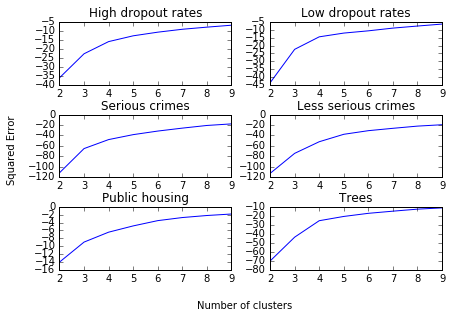

In [202]:
clusters = [i for i in range(2,10)]
fig, ax = plt.subplots(nrows=3,ncols=2)
fig.tight_layout()


plt.subplot(3,2,1)
plt.plot(clusters,squared_errors[0])
plt.title("High dropout rates")

plt.subplot(3,2,2)
plt.plot(clusters,squared_errors[1])
plt.title("Low dropout rates")

plt.subplot(3,2,3)
plt.plot(clusters,squared_errors[2])
plt.title("Serious crimes")

plt.subplot(3,2,4)
plt.plot(clusters,squared_errors[3])
plt.title("Less serious crimes")

plt.subplot(3,2,5)
plt.plot(clusters,squared_errors[4])
plt.title("Public housing")

plt.subplot(3,2,6)
plt.plot(clusters,squared_errors[5])
plt.title("Trees")

fig.text(0.5, -0.05, 'Number of clusters', ha='center')
fig.text(-0.05, 0.5, 'Squared Error', va='center', rotation='vertical')

plt.show()

Even though it's unclear on some of the data sets (especially less serious crimes and public housing) where the knee-point is, it seems to be around 4 clusters, so we'll try with 3, 4, 5 and 6 clusters. More clusters will lead to overfitting.

Let's next calculate the centers of the clusters, for the above mentioned division:

In [203]:
centerLists = [[] for x in xrange(6)]
for i in range(len(data_lists)):
    for j in range(1,5):
        centerLists[i].append(kmeans_lists[i][j].cluster_centers_.tolist())

In [206]:
colorList_school_high = ["#d5f4e6", "#80ced6", "#fefbd8", "#618685", "#92a8d1", "#034f84"]
colorList_school_low = ["#00111a", "#0077b3", "#66ccff", "#e6f7ff", "#0000ff", "#9933ff"]
colorList_crime_serious = ["#993333", "#ff6666", "#330011", "#ffe6ee", "#ff8000", "#fff2e6"]
colorList_crime_less = ["#1a0d00", "#b35900", "#ffbf80", "#fff2e6", "#808000", "#ffff99"]
colorList_public = ["#ffffff", "#9900cc", "#d98cb3", "#ff9999", "#ccccff", "#660066"]
colorList_tree = ["#004d00", "#c6ecd9", "#33ff33", "#e6ff99", "#00cc00", "#e6ffe6"]

colorLists = [colorList_school_high, colorList_school_low, colorList_crime_serious, colorList_crime_less, colorList_public, colorList_tree]

kmeans_colors = [[] for x in xrange(6)]
for i in range(len(kmeans_colors)):
    kmeans_colors[i] = [[] for x in xrange(4)]

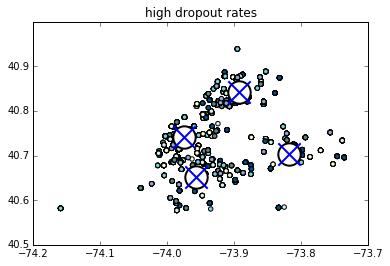

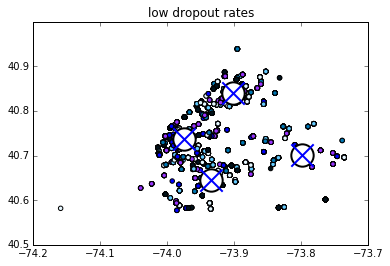

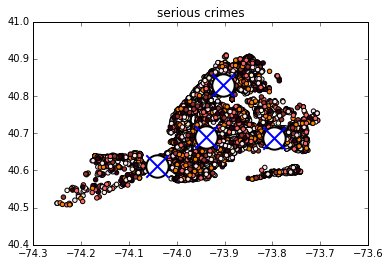

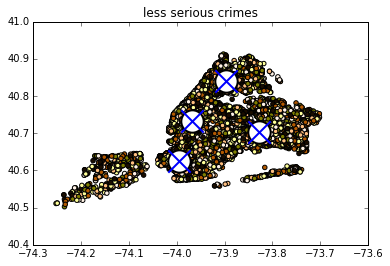

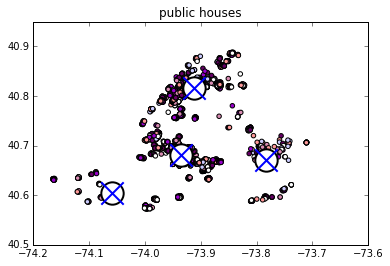

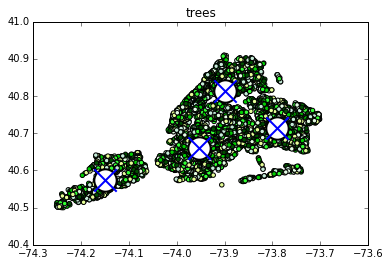

In [207]:
# Let's use python to scatter the points, with four clusters:

titles = ["high dropout rates", "low dropout rates", "serious crimes", "less serious crimes", "public houses", "trees"]

for i in range(len(data_lists)):
    pylab.title(titles[i])
    pylab.scatter(data_lists[i][['lon', 'lat']].as_matrix()[:,0],data_lists[i][['lon', 'lat']].as_matrix()[:,1], c=colorLists[i])
    # mark centroids as (X)
    pylab.scatter(centerListsX[i][1],centerListsY[i][1], marker='o', s = 500, linewidths=2, c='white')
    pylab.scatter(centerListsX[i][1],centerListsY[i][1], marker='x', s = 500, linewidths=2)
    pylab.show()

Next, we assign colors to clusters:

In [208]:
# we only want to take neighbours 3 to 6
for i in range(1,5):
    # we want the numbers of the clusters:
    for j in range(6):
        for k in range(len(kmeans_lists)):
            for l in range(len(kmeans_lists[k][i].labels_.tolist())):
                if kmeans_lists[k][i].labels_.tolist()[l] == j:
                    kmeans_colors[k][i-1].append(colorLists[k][j])

In [209]:
# We cut off a few decimal places to save memory
roundedListLat = []
roundedListLon = []
for i in range(len(data_lists)):
    roundedLat = [round(lat, 6) for lat in list(data_lists[i]['lat'])]
    roundedLon = [round(lon, 6) for lon in list(data_lists[i]['lon'])]
    roundedListLat.append(roundedLat)
    roundedListLon.append(roundedLon)    

Now we make new dataframes with the colors:

In [ ]:
clusterLocations_school_high = pd.DataFrame({ 'lon': roundedListLon[0], 'lat': roundedListLat[0], 'kmeans3': kmeans_colors[0][0], 'kmeans4': kmeans_colors[0][1], 'kmeans5': kmeans_colors[0][2], 'kmeans6': kmeans_colors[0][3], 'dropoutPerc': list(high_data_fix['dropoutperc'])})

In [ ]:
clusterLocations_school_low = pd.DataFrame({ 'lon': roundedListLon[1], 'lat': roundedListLat[1], 'kmeans3': kmeans_colors[1][0], 'kmeans4': kmeans_colors[1][1], 'kmeans5': kmeans_colors[1][2], 'kmeans6': kmeans_colors[1][3], 'dropoutPerc': list(low_data_fix['dropoutperc'])})

In [ ]:
clusterLocations_crime_serious = pd.DataFrame({ 'lon': roundedListLon[2], 'lat': roundedListLat[2], 'kmeans3': kmeans_colors[2][0], 'kmeans4': kmeans_colors[2][1], 'kmeans5': kmeans_colors[2][2], 'kmeans6': kmeans_colors[2][3]})

In [ ]:
clusterLocations_crime_less = pd.DataFrame({ 'lon': roundedListLon[3], 'lat': roundedListLat[3], 'kmeans3': kmeans_colors[3][0], 'kmeans4': kmeans_colors[3][1], 'kmeans5': kmeans_colors[3][2], 'kmeans6': kmeans_colors[3][3]})

In [ ]:
clusterLocations_public = pd.DataFrame({ 'lon': roundedListLon[4], 'lat': roundedListLat[4], 'kmeans3': kmeans_colors[4][0], 'kmeans4': kmeans_colors[4][1], 'kmeans5': kmeans_colors[4][2], 'kmeans6': kmeans_colors[4][3]})

In [ ]:
clusterLocations_tree = pd.DataFrame({ 'lon': roundedListLon[5], 'lat': roundedListLat[5], 'kmeans3': kmeans_colors[5][0], 'kmeans4': kmeans_colors[5][1], 'kmeans5': kmeans_colors[5][2], 'kmeans6': kmeans_colors[5][3]})

In [ ]:
# We save the cluster locations to csv-files
clusterLocations_school_high.to_csv('clusterLocations_school_high_final.csv', index=False)
clusterLocations_school_low.to_csv('clusterLocations_school_low_final.csv', index=False)
clusterLocations_crime_serious.to_csv('clusterLocations_crime_serious_final.csv', index=False)
clusterLocations_crime_less.to_csv('clusterLocations_crime_less_final.csv', index=False)
clusterLocations_public.to_csv('clusterLocations_public_final.csv', index=False)
clusterLocations_tree.to_csv('clusterLocations_tree_final.csv', index=False)

Next, we want to save the center locations as well:

In [231]:
centerListsX = [[] for x in xrange(6)]
centerListsY = [[] for x in xrange(6)]

for i in range(len(centerLists)):
    for j in range(len(centerLists[i])):
        centerListsX[i].append([x[0] for x in centerLists[i][j]])
        centerListsY[i].append([y[1] for y in centerLists[i][j]])

In [232]:
centers_2Csv = [[] for x in xrange(6)]
for i in range(len(centerListsX)):
    for j in range(len(centerListsX[i])):
        centerListsX[i][j].insert(0, "X_" + str(j+3))
        centerListsY[i][j].insert(0, "Y_" + str(j+3))
        centers_2Csv[i].append(centerListsX[i][j])
        centers_2Csv[i].append(centerListsY[i][j])

In [233]:
centersColors_school_high = []
colorVal_school_high = colorList_school_high
colorVal_school_high.insert(0,"centerColors")
centersColors_school_high = centers_2Csv[0]
centersColors_school_high.insert(0,colorVal_school_high)

In [241]:
with open("centers_colors_school_high_df.csv","w+") as f:
    writer = csv.writer(f)
    for values in izip_longest(*centersColors_school_high):
        writer.writerow(values)

In [242]:
colorVal_school_low = colorList_school_low
colorVal_school_low.insert(0,"centerColors")
centersColors_school_low = centers_2Csv[1]
centersColors_school_low.insert(0,colorVal_school_low)

In [244]:
with open("centers_colors_school_low_df.csv","w+") as f:
    writer = csv.writer(f)
    for values in izip_longest(*centersColors_school_low):
        writer.writerow(values)

In [245]:
colorVal_crime_serious = colorList_crime_serious
colorVal_crime_serious.insert(0,"centerColors")
centersColors_crime_serious = centers_2Csv[2]
centersColors_crime_serious.insert(0,colorVal_crime_serious)

In [247]:
with open("centers_colors_crime_serious_df.csv","w+") as f:
    writer = csv.writer(f)
    for values in izip_longest(*centersColors_crime_serious):
        writer.writerow(values)

In [248]:
colorVal_crime_less = colorList_crime_less
colorVal_crime_less.insert(0,"centerColors")
centersColors_crime_less = centers_2Csv[3]
centersColors_crime_less.insert(0,colorVal_crime_less)

In [250]:
with open("centers_colors_crime_less_df.csv","w+") as f:
    writer = csv.writer(f)
    for values in izip_longest(*centersColors_crime_less):
        writer.writerow(values)

In [251]:
colorVal_public = colorList_public
colorVal_public.insert(0,"centerColors")
centersColors_public = centers_2Csv[4]
centersColors_public.insert(0,colorVal_public)

In [255]:
with open("centers_colors_public_df.csv","w+") as f:
    writer = csv.writer(f)
    for values in izip_longest(*centersColors_public):
        writer.writerow(values)

In [253]:
colorVal_tree = colorList_tree
colorVal_tree.insert(0,"centerColors")
centersColors_tree = centers_2Csv[5]
centersColors_tree.insert(0,colorVal_tree)

In [256]:
with open("centers_colors_tree_df.csv","w+") as f:
    writer = csv.writer(f)
    for values in izip_longest(*centersColors_tree):
        writer.writerow(values)

We used those files to do some visualizations in javascript, using d3. The result was disappointing for $matplotlib$ and $d3$ alike, since the points in different clusters are not close to each other, which makes no sense for k-means. When trying different approaches to kmeans, we get a good result with sample data, but all of our own data comes as not being clustered in any way. We tried $kmeans$, $kmeans2$, three different ways of handling our data and even $DBscan$ to get the right clusters, but nothing seems to work. It always ends up looking like a knitted sweater. It's weird that we aren't able to get to the bottom of this, but maybe something about the structure of the data doesn't work with the algorithms. At least the centers are in the right places, even though the colors are far off track.


# 4. Visualizations
* Explain the visualizations you've chosen.
* Why are they right for the story you want to tell?

We'll start with the visualizations done in Python. We had a lot of data on the highschool dropout rates for different groups, so we'll start playing a bit around with that data.

We start by looking at the evolution in the mean dropout rates for all students in the data set enrolled in a four year program. 

In [ ]:
# It's a long code without a for-loop, we know, but we decided to let it slip since it's under ten items:
fourYearAll12 = fourYearAugustAll[fourYearAugustAll['year']==2012].reset_index()
fourYearAll11 = fourYearAugustAll[fourYearAugustAll['year']==2011].reset_index()
fourYearAll10 = fourYearAugustAll[fourYearAugustAll['year']==2010].reset_index()
fourYearAll09 = fourYearAugustAll[fourYearAugustAll['year']==2009].reset_index()
fourYearAll08 = fourYearAugustAll[fourYearAugustAll['year']==2008].reset_index()
fourYearAll07 = fourYearAugustAll[fourYearAugustAll['year']==2007].reset_index()
fourYearAll06 = fourYearAugustAll[fourYearAugustAll['year']==2006].reset_index()
fourYearAll05 = fourYearAugustAll[fourYearAugustAll['year']==2005].reset_index()

In [ ]:
fourYears = [fourYearAll12, fourYearAll11, fourYearAll10, fourYearAll09, fourYearAll08, fourYearAll07, fourYearAll06, fourYearAll05]
meanDropouts = []
for year in fourYears:
    meanDropouts.append(np.mean(list(year['dropoutperc'])))

In [ ]:
import plotly.tools as tls
tls.set_credentials_file(username='Helga_Svala', api_key='4bKIDgIeTf5LigEBfIo1')

import plotly.plotly as py
import plotly.graph_objs as go

N = 500
years = ['2012', '2011', '2010', '2009', '2008', '2007', '2006', '2005'] 

# Create a trace
trace = go.Scatter(
    x = years,
    y = meanDropouts
)

data = [trace]

layout = go.Layout(
    title='The mean dropout rate for all students enrolled in a four year program in August 2005-2012',
    xaxis=dict(
        title='Year of enrollment',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Mean dropout rate',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='styling-names')

We see that the dropout rate was highest for students enrolled in 2008 (the years 2007-2009) but has gotten steadily lower over the last few years.

Next, we want to see the development in dropout rates for different planned lengths of studies:

In [ ]:
# We don't have data from six years in august 2010
grad16 = [fourYear2012, fiveYear2011, sixYearJune2010]

meanDropouts16 = []
for year in grad16:
    meanDropouts16.append(np.mean(list(year['dropoutperc'])))

meanDropouts16

In [ ]:
N = 500
lengths = ['Four years', 'Five years', 'Six years'] 

# Create a trace
trace = go.Scatter(
    x = lengths,
    y = meanDropouts16
)

data = [trace]

layout = go.Layout(
    title='The mean dropout rate for all students planning to graduate in 2016',
    xaxis=dict(
        title='Planned length of studies',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#800080'
        )
    ),
    yaxis=dict(
        range=[5, 20],
        title='Mean dropout rate',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#800080'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='styling-names')

We see that, perhaps unsurprisingly, the dropout rate is much lower for those who plan four years for their studies than six years.

Now, we'll move on to the different ethnicities, where we take students enrolled for four years in August 2012:

In [ ]:
ethnicities = fourYearAugustEthnic2012.Category.unique()

In [ ]:
hispanic = fourYearAugustEthnic2012[fourYearAugustEthnic2012['Category']=='Hispanic']
asian = fourYearAugustEthnic2012[fourYearAugustEthnic2012['Category']=='Asian']
black = fourYearAugustEthnic2012[fourYearAugustEthnic2012['Category']=='Black']
white = fourYearAugustEthnic2012[fourYearAugustEthnic2012['Category']=='White']
multiracial = fourYearAugustEthnic2012[fourYearAugustEthnic2012['Category']=='Multi-Racial']
native = fourYearAugustEthnic2012[fourYearAugustEthnic2012['Category']=='Native American']

In [ ]:
ethnicityList = [hispanic, asian, black, white, multiracial, native]
meanDropoutsEthnic = []
for ethnicity in ethnicityList:
    meanDropoutsEthnic.append(np.mean(list(ethnicity['dropoutPerc'])))

ethnicities12 = ['Hispanic', 'Asian', 'Black', 'White', 'Multi-Racial', 'Native American']

In [ ]:
data = [go.Bar(
            x=ethnicities12,y=meanDropoutsEthnic,
            marker=dict(
                color=['#C06074', '#FFD7DF', '#6E333F', '#DAB0B8', '#FF1642', '#9B1C34'],
                line=dict(
                    color='#522C45',
                    width=1.5),
            ),
            opacity=0.6
        )]

layout = go.Layout(
    title = 'The mean dropout rate for all registered ethnicity groups enrolled in 2012',
    xaxis = dict(
    title='Ethnicity groups'),
    yaxis = dict(
    title='Mean dropout rate'),
    annotations=[
        dict(x=xi,y=yi,
             text=str(yi),
             xanchor='center',
             yanchor='bottom',
             showarrow=False,
        ) for xi, yi in zip(ethnicities12, meanDropoutsEthnic)]
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

These results are very stereotypical. The Asian have the lowest dropout rates, followed closely by Caucasians. It's higher for black, hispanic and especially Native American students, which is a known problem in the U.S. The Multi-Racial have an extremely low dropout rate, but we only had nine data samples from then, out of which seven had a zero percent dropout rate.

Let's move on to the genders:

In [ ]:
male = fourYearAugustGender2012[fourYearAugustGender2012['Category']=='Male']
female = fourYearAugustGender2012[fourYearAugustGender2012['Category']=='Female']

In [ ]:
genderList = [male, female]
meanDropoutsGender = []
for gender in genderList:
    meanDropoutsGender.append(np.mean(list(gender['dropoutPerc'])))

genders12 = ['Female', 'Male']

In [ ]:
data = [go.Bar(
            x=genders12,y=meanDropoutsGender,
            marker=dict(
                color=['#B99CEE', '#631FE1'],
                line=dict(
                    color='#42265C',
                    width=1.5),
            ),
            opacity=0.6
        )]

layout = go.Layout(
    title = 'The mean dropout rate for the different genders enrolled in 2012',
    xaxis = dict(
    title='Genders'),
    yaxis = dict(
    title='Mean dropout rate'),
    annotations=[
        dict(x=xi,y=yi,
             text=str(yi),
             xanchor='center',
             yanchor='bottom',
             showarrow=False,
        ) for xi, yi in zip(genders12, meanDropoutsGender)]
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

The difference between the genders is not very big, but females have a slightly higher dropout rate than males. The lists showed 451 females and 445 males so the difference cannot be attributed to uneven data sets.

Finally, we look at the difference between districts in New York City:

In [ ]:
manhattan = fourYear2012[fourYear2012['district']=='New York']
brooklyn = fourYear2012[fourYear2012['district']=='Brooklyn']
bronx = fourYear2012[fourYear2012['district']=='Bronx']
queens = fourYear2012[fourYear2012['district']=='Queens']
statenisland = fourYear2012[fourYear2012['district']=='Staten Island']

In [ ]:
districtList = [manhattan, brooklyn, bronx, queens, statenisland]
meanDropoutsDistrict = []
for district in districtList:
    meanDropoutsDistrict.append(np.mean(list(district['dropoutperc'])))

districts12 = ['Manhattan', 'Brooklyn', 'Bronx', 'Queens', 'Staten Island']

In [ ]:
data = [go.Bar(
            x=districts12,y=meanDropoutsDistrict,
            marker=dict(
                color=['#00FFB2', '#008A61', '#73AB9A', '#94DCC6', '#009B6B'],
                line=dict(
                    color='#0D372A',
                    width=1.5),
            ),
            opacity=0.6
        )]

layout = go.Layout(
    title = 'The mean dropout rate for the different districts enrolled in 2012',
    xaxis = dict(
    title='Districts'),
    yaxis = dict(
    title='Mean dropout rate'),
    annotations=[
        dict(x=xi,y=yi,
             text=str(yi),
             xanchor='center',
             yanchor='bottom',
             showarrow=False,
        ) for xi, yi in zip(districts12, meanDropoutsDistrict)]
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

These results are clearly skewed, since Staten Island has by far the lowest dropout rates of all the districts in New York (http://www.silive.com/news/2016/01/staten_islands_high_school_gra.html). When looking closely at the data, we see that only two samples from Staten Island made it to the data set after cleaning, and both of them had a dropout percentage of 21.43. Otherwise, from other visualized data (the k-nearest neighbours for example), Bronx seems to have the highest dropout rates, which correlates with the plot.

Other visualizations are done on the website, with d3. They show a map of New York City where the user can choose what she wants to see of all the data sets. Since that is not a very descriptive way of showing something, we also have maps where we can compare the centers of K-means clusters for a different number of clusters. It's for example possible to compare the clusters for serious and less serious crimes, as for high and low dropout rates. All hoping to shed some light on the life in New York City.

Finally, we have a scatter plot where it's possible to compare crimes in different boroughs in New York City.

# 5. Discussion. Think critically about your creation
* What went well?,
* What is still missing? What could be improved?, Why?

The high school dropout data set was very good when we had finally found the geocoordinates, and told several stories. The machine learning for KNN went well, although we're not sure how good the accuracy was. The plotting of the k-means maps also went well. However, we are disappointed in the clusters themselves in k-means, and would really want to figure out the reason behind them. Some more interaction could be implemented on the website, to tell a more comprehensive story of this city, since the analysis we have already done doesn't really give us any concrete results, although it has given us many smaller interesting results. For example, with more time, we would have implemented some kind of a toggle button to toggle smoothly between k-means data in different school dropout rates and crimes. Maybe we can do that in the summer. :)